# Предсказание выполнения элементов одиночными фигуристами

**Заказчик**<br>
Компания [GoProtect](https://www.goprotect.ru/)

**Описание проекта**<br>
Сервис  “Мой Чемпион” помогает спортивным школам фигурного катания, тренерам мониторить результаты своих подопечных и планировать дальнейшее развитие спортсменов.

**Цель**<br>
Создать модель, помогающую находить элементы, которые могут быть успешно исполнены спортсменом на соревновании.
Сервис будет прогнозировать прогресс и возможное выполнение тех или иных элементов программы по истории предыдущих выступлений и выполнения элементов на соревнованиях.

**Данные**<br>
Исторические данные об участии и результатах соревнований фигуристов-одиночников из разных спортивных школ.

**Дополнительная информация**<br>
Актуальный список элементов фигурного катания можно посмотреть [здесь](https://eislauf-union.de/files/users/997/Elemente-Liste2023_24.pdf)

[Базовая стоимость элементов](https://fsrussia.ru/files/docs/SSPScomm_2475.pdf)

Правила оценивания, [Руководства для технических бригад](https://fsrussia.ru/files/docs/tp_handbook_singles_2324.pdf)


## План работы

1. Предобработка и исследовательский анализ данных
- загрузка данных и предварительный анализ
- исследовательский анализ данных
    - анализ пропусков и аномалий
    - feature engineering
    - объединение данных
    - обработка пропусков
    - анализ на заимодействие признаков
    - feature selection
2. Исследование моделей
- разбиение на тестовую и обучающую выборки
- исследование базовой модели
    - CatBoostClassifier для multi-label классификации, предсказание ошибок элементов
    - CatBoostRegressor для предсказания goe
3. Проверка моделей на тестовых данных
- определение итоговой
- проверка модели на адекватность (сравнение с константной моделью)
- анализ важности признаков для выбранной модели

In [ ]:
# import libraries
import datetime as dt
import os
import re
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from catboost.utils import eval_metric
from phik.report import correlation_report, plot_correlation_matrix
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error

In [ ]:
# display settings
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)
pd.set_option("display.precision", 4)

sns.set_style("darkgrid")

%matplotlib inline

In [ ]:
# set random state
RANDOM_STATE = 42

# data path
PATH = ['Datasets']

# list of dataset names
DATA = ['total_scores', 'tournament_scores', 'tournaments', 'units']

# minimal number of tournaments per skater for prediction
N_TOURN = 2

# Desired season of tournaments (ex: 2090/2091 -> 2090) for prediction
SEASON = 2091

## Загрузка и обзор данных

### Загрузка данных

Создадим функцию для чтения файлов.

In [ ]:
# define function to read files and display information about the data
def read_file(dataset):
    """ Функция принимает строку - название файла.
    Читает данные, выводит основную информацию по файлу,
    проверяет на наличие явных дубликатов и пропусков.
    Возвращает датафрейм."""

    # reading files
    filename = dataset + '.csv'
    try:
        df = pd.read_csv(os.path.join(*PATH, filename))
    except:
        df = pd.read_csv('/datasets/GoProtect/' + filename)

    # get first and last 5 rows
    display(df.head())

    # get information about the data
    print()
    print(df.info())

    # check for duplicates
    print()
    if df.duplicated().sum() > 0:
        print('В данных есть явные дубликаты')
    else:
        print('В данных нет явных дубликатов')

    # check for NaN
    if df.isna().sum().sum() > 0:
        print('В данных есть пропущенные значения')
    else:
        print('В данных нет пропущенных значений')

    # number of unique values
    print('\033[1m\nКоличество уникальных значений\033[1m')
    display(df.nunique())

    return df

Загрузим файлы, для этого создадим словарь датафреймов, где ключи - названия датафреймов.

In [ ]:
# create dict of dataframes
data = {}

for dataset in DATA:
    # print name of dataset
    print('\033[1m'+dataset.upper()+'\033[0m')
    print('___________________')

    df = read_file(dataset)
    print()

    # add dataframe to the dict of dataframes
    data[dataset] = df

TOTAL_SCORES
___________________


,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
0,442027,304,4785,47.2,43.47,102.70,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине программы (10%),2,293.74,2
1,442028,604,4785,45.4,46.71,101.19,54.48,0.0,18,2,Короткая программа,q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%),1,294.75,1
2,442029,409,4785,44.0,46.82,99.20,52.38,0.0,6,3,Короткая программа,q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%),4,285.57,4
3,442030,524,4785,46.2,44.86,91.84,47.98,-1.0,3,4,Короткая программа,q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%) F Падение в элементе,3,292.42,3
4,442031,412,4785,44.2,42.59,89.73,48.14,-1.0,15,5,Короткая программа,q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%) F Падение в элементе,6,265.34,6



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21284 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14  overall_place_str    10814 non-null  object 
dtypes: float64(6), int64(6), object(3)


id                     21301
unit_id                 3393
tournament_id            142
base_score              5454
components_score        3926
total_score             9575
elements_score          6191
decreasings_score         12
starting_place            55
place                     51
segment_name              17
info                    1210
overall_place             51
overall_total_score     8864
overall_place_str         53
dtype: int64


TOURNAMENT_SCORES
___________________


,id,total_score_id,title,decrease,base_score,goe,avg_score
0,1,1,2A,NaN,3.3,0.66,3.96
1,2,1,3F+3Lo,NaN,10.2,-0.11,10.09
2,3,1,3Lz,NaN,0.0,-1.30,5.19
3,4,1,CCoSp4,NaN,3.5,0.56,4.06
4,5,1,FCSp4,NaN,3.2,0.64,3.84



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              172158 non-null  int64  
 1   total_score_id  172158 non-null  int64  
 2   title           172158 non-null  object 
 3   decrease        41185 non-null   object 
 4   base_score      172158 non-null  float64
 5   goe             172158 non-null  float64
 6   avg_score       172158 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 9.2+ MB
None

В данных нет явных дубликатов
В данных есть пропущенные значения

Количество уникальных значений


id                172158
total_score_id     21301
title               3425
decrease              32
base_score           376
goe                  599
avg_score           1552
dtype: int64


TOURNAMENTS
___________________


,id,date_start,date_end,origin_id
0,1,2090-11-29,2090-12-01,2.0
1,2,2091-03-06,2091-03-10,1.0
2,3,2090-10-05,2090-10-08,2.0
3,4,2090-10-18,2090-10-21,2.0
4,5,2090-10-21,2090-10-24,2.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          142 non-null    int64  
 1   date_start  142 non-null    object 
 2   date_end    142 non-null    object 
 3   origin_id   142 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ KB
None

В данных нет явных дубликатов
В данных нет пропущенных значений

Количество уникальных значений


id            142
date_start    127
date_end      126
origin_id       3
dtype: int64


UNITS
___________________


,id,color,school_id
0,9474,green,244.0
1,733,green,203.0
2,734,green,235.0
3,735,green,168.0
4,736,green,168.0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4596 non-null   int64  
 1   color      4595 non-null   object 
 2   school_id  4007 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 107.8+ KB
None

В данных нет явных дубликатов
В данных есть пропущенные значения

Количество уникальных значений


id           4596
color           2
school_id     239
dtype: int64

**Вывод:** имеются данные о 4596 спортсменах из 239 спортивных школ (идентификаторы школ иногда пропущены). Всего имеется информация для 142 соревнований в 3х локациях, иногда разные соревнования начинались в один день. В данных о выступлениях спортсменов есть пропуски по некоторым показателям - тип программы, общая оценка, информация о выступлении, в данных о выполненных в рамках выступления элементах -  только для четверти случаев указана информация о снижении оценки/присвоении бонуса (возможно снижений и бонусов не было).

## Анализ и предобработка данных
Посмотрим на каждый датасет подробнее

### units
В этом датасете указано в какой категории соревнований участвовал каждый спортсмен и из какой он школы.

In [ ]:
units = data['units']
units = units.rename(columns={'id': 'unit_id'})

In [ ]:
# percentage of NaN
print('Число пропущенных значений:')
units.isna().sum()

Процент пропущенных значений:


unit_id        0
color          1
school_id    589
dtype: int64

Заполним пропущенные значения индентификатора школы 0, а категории соревнования 'no info'

In [ ]:
# fill Nan
units['school_id'] = units['school_id'].fillna(0)
units['color'] = units['color'].fillna('no info')
units.isna().sum()

unit_id      0
color        0
school_id    0
dtype: int64

Изменим категории данных, идентификаторы - на целочисленный тип, категорию соревнований - на категорию.

In [ ]:
# Change data type
units[['unit_id', 'school_id']] = units[['unit_id', 'school_id']].astype(int)
units['color'] = units['color'].astype('category')
units.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   unit_id    4596 non-null   int64   
 1   color      4596 non-null   category
 2   school_id  4596 non-null   int64   
dtypes: category(1), int64(2)
memory usage: 76.6 KB


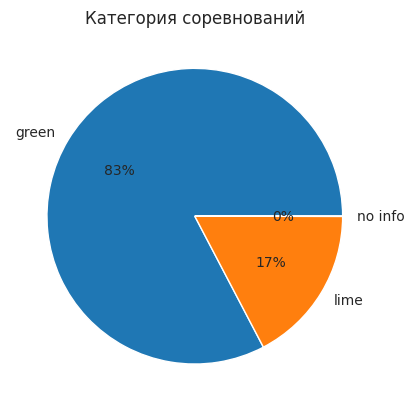

In [ ]:
# Pie chart
units.color.value_counts().plot(
    kind='pie',
    wedgeprops = {'linewidth' : 1, 'edgecolor' : 'white'},
    autopct = '%1.0f%%')
plt.title('Категория соревнований')
plt.ylabel(None)
plt.show()

Видно, что, спортсменов, участвующих в категории  'lime', в 4 раза меньше. Посмотрим на "размер" школ, в зависимости от количества представляющих их спортсменов.

In [ ]:
print('Количество спортсменов из разных школ:')
units.school_id.value_counts()

Количество спортсменов из разных школ:


school_id
0      589
62     348
198    345
111    255
38     241
      ... 
2        1
267      1
163      1
191      1
227      1
Name: count, Length: 240, dtype: int64

In [ ]:
# schools with < 10 units
print('Количество школ, из которых < 10 спортсменов:')
print('Количество спортсменов / количество школ:')
units.school_id.value_counts()[units.school_id.value_counts() < 10].value_counts()

Количество школ, из которых < 10 спортсменов:
Количество спортсменов / количество школ:


count
1    49
2    26
3    19
4    18
5    15
8     9
7     8
6     8
9     3
Name: count, dtype: int64

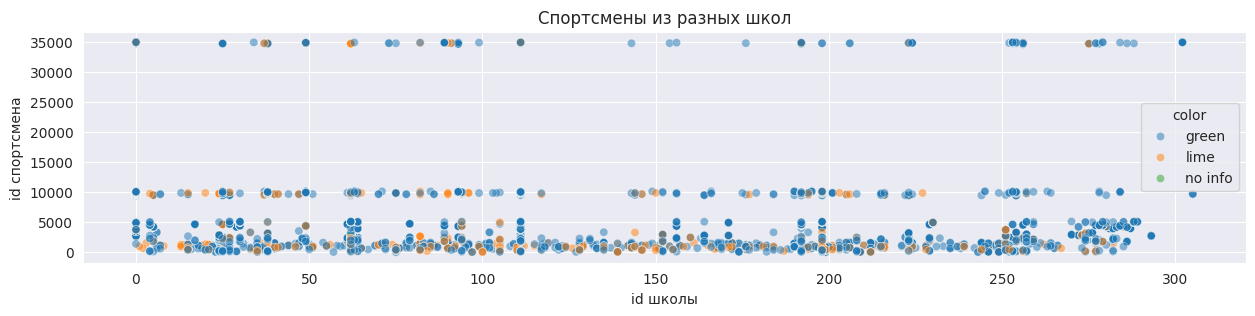

In [ ]:
# scatterplot
plt.figure(figsize=(15, 3))
sns.scatterplot(data=units[units['school_id'] < 1000],
                x='school_id',
                y='unit_id',
                hue='color',
                alpha = .5)
plt.title('Спортсмены из разных школ')
plt.ylabel('id спортсмена')
plt.xlabel('id школы')
plt.show()

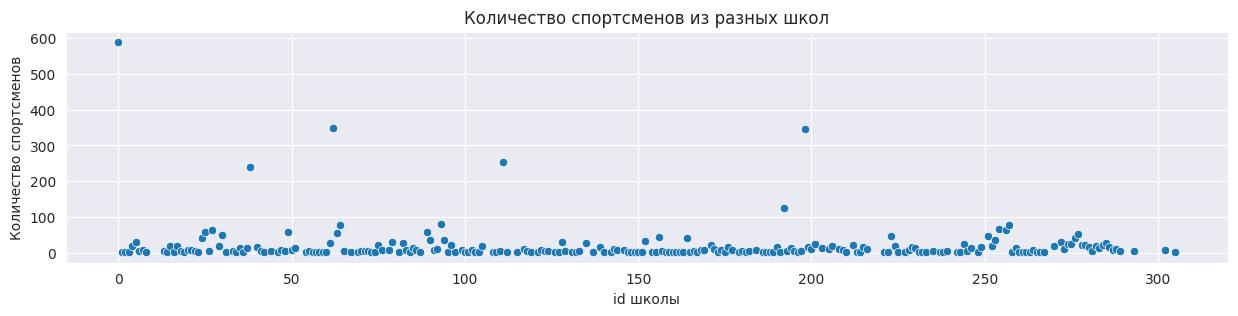

In [ ]:
# scatterplot
plt.figure(figsize=(15, 3))
sns.scatterplot(data=units[units['school_id'] < 1000]
                .groupby('school_id', as_index=False)
                .unit_id.nunique(),
                x='school_id',
                y='unit_id')
plt.title('Количество спортсменов из разных школ')
plt.ylabel('Количество спортсменов')
plt.xlabel('id школы')
plt.show()

In [ ]:
print('Статистика по количеству спортсменов из разных школ')
units.query('school_id>0').groupby('school_id').unit_id.nunique().describe()

Статистика по количеству спортсменов из разных школ


count    239.0000
mean      16.7657
std       40.9571
min        1.0000
25%        2.0000
50%        5.0000
75%       16.0000
max      348.0000
Name: unit_id, dtype: float64

**Вывод:**

Видно, что есть школы, представленные более 200 смортсменами, а 49 школ представлены лишь одним спортсменом. В целом, количество спортсменов, представляющих школу не превышает 16, а в половине случаев - не более 5. Можно предположить, что школы, где много спортсменов - в городах, у них может быть больше ресурсов и может быть выше уровень подготовки спортсменов, поэтому фактор того, из какой школы спортсмен, может влиять на его выступление.
Можно разделить школы на категории по количеству учеников и использовать это как признак. Спортсмены, участвующие в разных категориях соревнований, не принадлежат к определенным школам, категории представлены неодинаково - спортсменов в категории 'green' в 4 раза больше.

### tournaments
В данном датасете представлена информация о турнирах, их дате начала-окончания и месте проведения.

In [ ]:
tournaments = data['tournaments']
tournaments = tournaments.rename(columns={'id': 'tournament_id'})

In [ ]:
# Change data type
tournaments[['tournament_id', 'origin_id']] = tournaments[['tournament_id', 'origin_id']].astype(int)
tournaments['origin_id'] = tournaments['origin_id'].astype('category')
tournaments['date_start'] = pd.to_datetime(tournaments['date_start'])
tournaments['date_end'] = pd.to_datetime(tournaments['date_end'])
tournaments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   tournament_id  142 non-null    int64         
 1   date_start     142 non-null    datetime64[ns]
 2   date_end       142 non-null    datetime64[ns]
 3   origin_id      142 non-null    category      
dtypes: category(1), datetime64[ns](2), int64(1)
memory usage: 3.7 KB


Вычислим длительность каждого турнира, длительные турниры могут быть более сложные и серьезные, а это может влиять на результаты выступления спортсмена. Кроме того, в них могут участвовать более сильные спортсмены.

In [ ]:
# Calculate difference in days
tournaments['duration'] = ((tournaments['date_end'] - tournaments['date_start']).dt.days + 1).astype(int)

In [ ]:
# descriptive statistics
tournaments.describe()

,tournament_id,date_start,date_end,duration
count,142.0000,142,142,142.0000
mean,2671.2324,2091-06-03 12:10:08.450704384,2091-06-05 23:39:43.098591744,3.4789
min,1.0000,2089-09-20 00:00:00,2089-09-23 00:00:00,1.0000
25%,38.2500,2090-12-27 00:00:00,2091-01-01 06:00:00,3.0000
50%,93.5000,2091-04-15 12:00:00,2091-04-17 12:00:00,3.0000
75%,6692.5000,2092-01-06 12:00:00,2092-01-08 06:00:00,4.0000
max,7117.0000,2092-04-29 00:00:00,2092-05-03 00:00:00,7.0000
std,3129.1488,NaN,NaN,1.1344


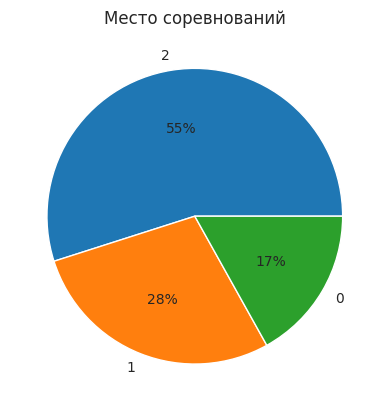

In [ ]:
# Pie chart
tournaments.origin_id.value_counts().plot(
    kind='pie',
    wedgeprops = {'linewidth' : 1, 'edgecolor' : 'white'},
    autopct = '%1.0f%%')
plt.title('Место соревнований')
plt.ylabel(None)
plt.show()

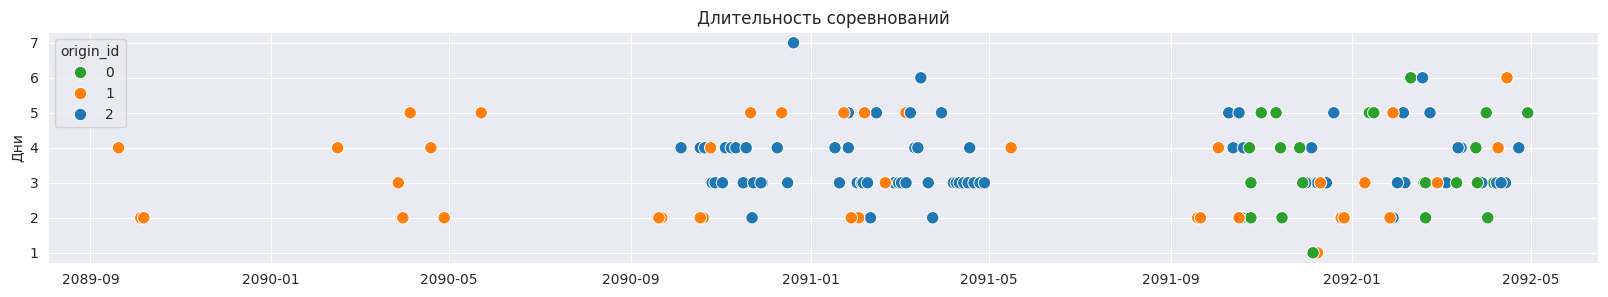

In [ ]:
# scatterplot
plt.figure(figsize=(20,3))
sns.scatterplot(data=tournaments,
                x='date_start',
                y='duration',
                hue='origin_id',
                s=80,
                palette={0: '#2ca02c', 1: '#ff7f0e', 2: '#1f77b4'})
plt.title('Длительность соревнований')
plt.ylabel('Дни')
plt.xlabel(None)
plt.show()

In [ ]:
# tournaments lasted 1 day
tournaments[tournaments['duration']<2]

,tournament_id,date_start,date_end,origin_id,duration
90,4862,2091-12-09,2091-12-09,1,1
108,6854,2091-12-06,2091-12-06,0,1


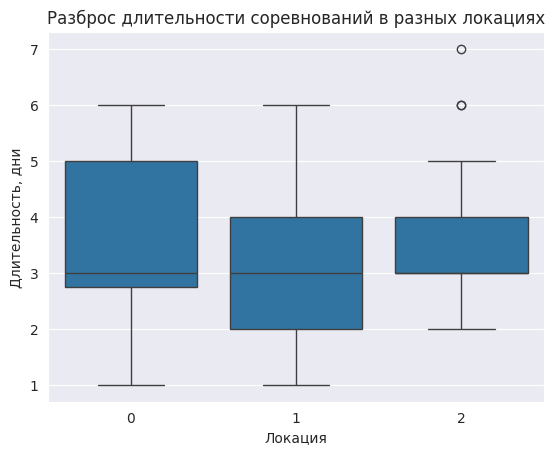

In [ ]:
# boxplots
sns.boxplot(
    data=tournaments,
    x='origin_id',
    y='duration')

plt.title('Разброс длительности соревнований в разных локациях')
plt.xlabel('Локация')
plt.ylabel('Длительность, дни')
plt.show()

Присвоим турнирам последовательные номера в зависимости от сезона.

In [ ]:
# Vectorized season calculation without apply
tournaments['season'] = tournaments['date_start'].dt.year
tournaments.loc[tournaments['date_start'].dt.month < 9, 'season'] -= 1

# Sort by season and date_start
tournaments = tournaments.sort_values(by=['season', 'date_start']).reset_index(drop=True)

# Assign order number within each season
tournaments['tournament_order'] = (tournaments.groupby('season').cumcount() + 1).astype(int)

In [ ]:
print('Количество турниров в сезоне')
tournaments.groupby('season')['tournament_order'].max()

Количество турниров в сезоне


season
2089    11
2090    67
2091    64
Name: tournament_order, dtype: int64

**Вывод:**

Всего имеются данные о 142 турнирах в 3х разных локациях за три сезона, видно, что сезон длится примерно с сентября по май (2089/2090, 2090/2091, 2091/2092 года закодированы). Видны летние и зимние "каникулы". Для сезона 2089 информации намного меньше - только об 11 турнирах в одной локации. Больше половины турниров во локации 2 - но она представлена только двумя последними сезонами, информация о трех сезонах только для локации 1, информация о турнирах во всех 3 локациях есть только для последнего сезона. Вероятно имеет смысл рассмотреть для предсказания результатов спортсмена только его, так как от места проведения ссоревнования может зависить и его уровень, а значит и "умения" спортсмена. Длительность соревнований как правило около 3-4 дней, но иногда может быть и 7, а для пары соревнований - всего 1 день. Длительность соревнований несколько неодинакова в зависимости от локации, но в целом сходжа - медианная длительность равна 3 дням.

### total_scores

В данном датасете представлены общие данные о выступлениях спортсменов в разных программах в рамках турниров. Даны оценки техники и "артистизма", информация о судейских снижениях за ошибки, месте спортсмена перед и после выступления.

In [ ]:
t_scrs = data['total_scores']
t_scrs = t_scrs.rename(columns={'id': 'total_score_id'})

In [ ]:
t_scrs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total_score_id       21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21284 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14  overall_place_str    10814 non-null  object 
dtypes: float64(6), int64(6), object(3)
m

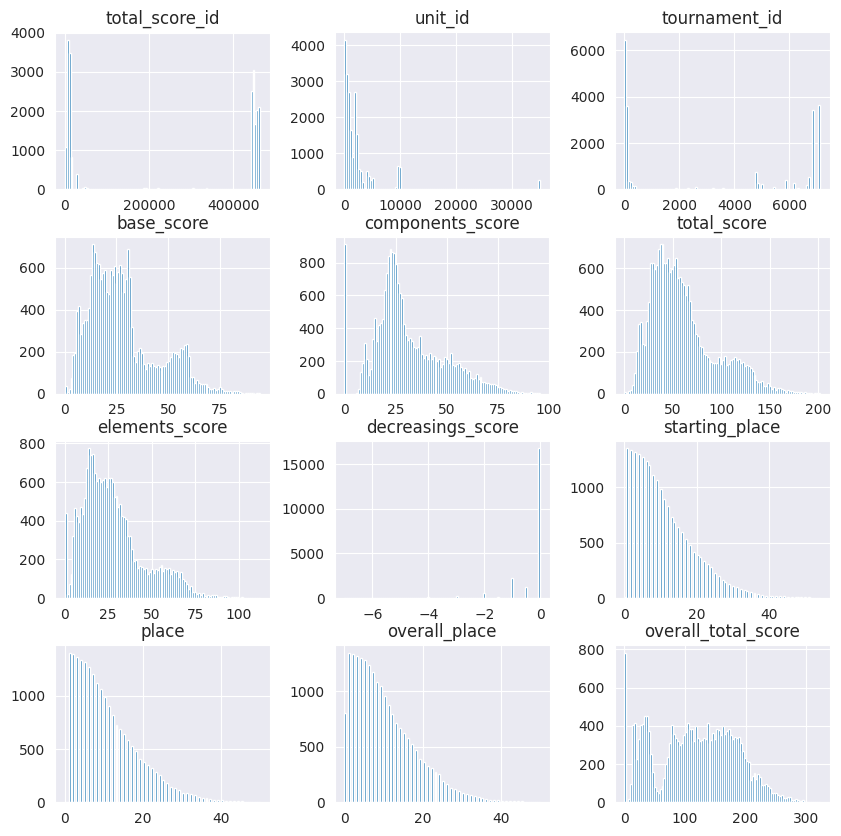

In [ ]:
# distribution histograms
t_scrs.hist(figsize=(10, 10), bins=100)
plt.show()

In [ ]:
# descriptive statistics
t_scrs.drop(['total_score_id', 'unit_id', 'tournament_id'], axis=1).describe()

,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,overall_place,overall_total_score
count,21301.0000,21301.0000,21301.0000,21301.0000,21301.0000,21301.0000,21301.0000,21301.0000,21284.0000
mean,27.8098,31.3244,60.4100,27.8365,-0.2410,10.9628,10.6199,10.1181,117.4434
std,16.3371,17.3302,33.5981,17.7458,0.5776,8.3523,8.0628,8.0039,66.3300
min,0.0000,0.0000,0.0000,0.0000,-7.0000,0.0000,0.0000,0.0000,0.0000
25%,15.5600,20.4200,35.8800,14.8800,0.0000,5.0000,4.0000,4.0000,69.3150
50%,24.4900,26.6600,52.6300,24.2700,0.0000,9.0000,9.0000,8.0000,119.6600
75%,35.1100,41.6000,75.7200,35.9100,0.0000,15.0000,15.0000,15.0000,168.7000
max,94.4200,95.9000,201.6500,112.4200,0.0000,54.0000,50.0000,50.0000,323.0500


In [ ]:
print('Количество пропущенных значений')
t_scrs.isna().sum()

Количество пропущенных значений


total_score_id             0
unit_id                    0
tournament_id              0
base_score                 0
components_score           0
total_score                0
elements_score             0
decreasings_score          0
starting_place             0
place                      0
segment_name              17
info                     581
overall_place              0
overall_total_score       17
overall_place_str      10487
dtype: int64

В данных есть пропущенные значения, для 17 программ выступления не указан тип общая оценка, в 581ой не заполнено info.

In [ ]:
# Data without segment_name
t_scrs[t_scrs['segment_name'].isna()].sort_values(by='unit_id')

,total_score_id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
702,442647,9509,4862,0.0,15.83,15.83,0.0,0.0,1,1,NaN,NaN,0,NaN,NaN
693,442643,9510,4862,0.0,16.00,16.00,0.0,0.0,1,1,NaN,NaN,0,NaN,NaN
686,442636,9510,4862,0.0,16.00,16.00,0.0,0.0,1,1,NaN,NaN,0,NaN,NaN
704,442650,9511,4862,0.0,13.92,13.92,0.0,0.0,1,2,NaN,NaN,0,NaN,NaN
680,442631,9522,4862,0.0,15.33,15.33,0.0,0.0,1,1,NaN,NaN,0,NaN,NaN
689,442639,9522,4862,0.0,15.33,15.33,0.0,0.0,1,1,NaN,NaN,0,NaN,NaN
681,442632,9523,4862,0.0,13.92,13.92,0.0,0.0,2,2,NaN,NaN,0,NaN,NaN
690,442640,9523,4862,0.0,13.92,13.92,0.0,0.0,2,2,NaN,NaN,0,NaN,NaN
685,442635,9524,4862,0.0,11.99,11.99,0.0,0.0,1,1,NaN,NaN,0,NaN,NaN
691,442641,9529,4862,0.0,12.58,12.58,0.0,0.0,3,3,NaN,NaN,0,NaN,NaN


В данных с пропуском значений типа программы много и других пропусков, возможно их стоит удалить, но пока оставим - данные для этих выступлений могут быть в датасете с информацией об элементах в каждом выступлении. Пропуски в информации заменим на 'no info'

In [ ]:
# fill Nan
t_scrs['info'] = t_scrs['info'].fillna('no info')

In [ ]:
# duplicates
print('Количество дубликатов, без учета id выступления')
t_scrs.duplicated(subset=list(t_scrs.drop(['total_score_id'], axis=1))).sum()

Количество дубликатов, без учета id выступления


32

In [ ]:
print('Одинаковые ли турниры в датасетах?')
set(tournaments.tournament_id)==set(t_scrs.tournament_id)

Одинаковые ли турниры в датасетах?


True

Изучим признаки по-отдельности.

####segment_name

In [ ]:
# number of different segment names
print('Количество выступлений')
t_scrs.segment_name.value_counts()

Количество выступлений


segment_name
Произвольная программа     9487
Короткая программа         7881
Произвольная программа.    2428
Элементы                    601
Прыжки                      254
Пpoизвoльнaя пpoгpaммa      159
Кopoткaя пpoгpaммa          101
Кoроткая программа          100
Элeмeнты                     58
Kopoткaя пpoгpaммa           58
Произвольнaя программа       43
Прoизвольная прoграмма       38
Пpoизвольная программа       30
Коpоткая программа           18
Интерпретация.               17
Пpoизвольнaя программа        7
Интерпретация                 4
Name: count, dtype: int64

Видно, что названи программ повторяются, вероятно смешаны кириллические и латинские символы, есть посторонние знаки. Напишем функцию для "перевода" всех визуально схожих кириллических символов в латинские и наоборот.

In [ ]:
# Function to replace characters based on the specified translation direction
def replace_cyrillic_latin(text, translate='cyrillic_latin'):
    '''
    Функция принимает строку и в зависимости от параметра translate
    переводит все визуально-схожие символы в латинские или кириллические.
    Возвращает "переведенную строку.
    '''
    if pd.isna(text):
        return text  # Return NaN unchanged
    if translate == 'latin_cyrillic':
        # Translation table: mapping Latin characters to Cyrillic equivalents
        table = str.maketrans('ABCEHKMOPCTXacexopcyx', 'АВСЕНКМОРСТХасехорсух')
    elif translate == 'cyrillic_latin':
        # Translation table: mapping Cyrillic characters to Latin equivalents
        table = str.maketrans('АВСЕНКМОРСТХасехорсух', 'ABCEHKMOPCTXacexopcyx')
    else:
        raise ValueError("Invalid value for translate parameter. Use 'latin_cyrillic' or 'cyrillic_latin'.")

    return text.translate(table)

In [ ]:
# Translate 'segment_name' column to replace latin characters with cyrillic
t_scrs['segment_name'] = t_scrs['segment_name'].map(lambda x: replace_cyrillic_latin(x, translate='latin_cyrillic'))

# Extract only Cyrillic characters and spaces
t_scrs['segment_name'] = t_scrs['segment_name'].str.extract('([а-яё\s]+)', flags=re.IGNORECASE)

In [ ]:
# number of different segment names
print('Количество выступлений')
t_scrs.segment_name.value_counts()

Количество выступлений


segment_name
Произвольная программа    12192
Короткая программа         8158
Элементы                    659
Прыжки                      254
Интерпретация                21
Name: count, dtype: int64

Видно, что есть 5 возможных программ, возможно есть не только взрослые спортсмены, но и юниоры - поэтому помимо короткой и произвольной программ есть еще и другие, но их значительно меньше. Количество произвольных программ больше, чем коротких, что странно, так как их должно быть или равное количество, или меньше, вероятно у нас имеются не все данные. Посмотрим, какие программы обычно выполняли спортсмены в турнире.

Изменим название программ: Произвольная программа - free, Короткая программа - short, Элементы, Прыжки, Интерпретация - other.




In [ ]:
# change segment names
seg_dict = {'Короткая программа': 'short',
            'Произвольная программа': 'free',
            'Элементы': 'other',
            'Прыжки': 'other',
            'Интерпретация': 'other'}

t_scrs['segment_name'] = t_scrs[t_scrs['segment_name'].notna()]['segment_name'].map(seg_dict)
t_scrs['segment_name'].value_counts()

segment_name
free     12192
short     8158
other      934
Name: count, dtype: int64

Посмотрим, когда у участника соревнования меньше двух программ

In [ ]:
# create lists with segments for each unit in each tournament
res = t_scrs.groupby(['tournament_id', 'unit_id'], as_index=False).agg({'segment_name': lambda x: list(x)})

In [ ]:
# only 1 segment
res[res['segment_name'].apply(lambda x: len(x) < 2)].segment_name.value_counts()

segment_name
[free]     4094
[short]     338
[other]      56
[nan]         5
Name: count, dtype: int64

В более 4000 случаях есть данные только о произвольной программе, возможно нам просто не предоставлены данные о короткой, посмотрим, когда программ больше 1ой

In [ ]:
# > 2 segments
res[res['segment_name'].apply(lambda x: len(x) > 1)]['segment_name'].apply(lambda x: sorted(x)).value_counts()

segment_name
[free, short]                                           7130
[free, other, short]                                     619
[free, other]                                            197
[free, free]                                              42
[other, short]                                            38
[free, free, short, short]                                15
[nan, nan]                                                 6
[free, free, other, other]                                 6
[free, free, short]                                        3
[free, free, other]                                        2
[free, free, free, free, other]                            2
[free, free, free, free, other, other, other, other]       2
Name: count, dtype: int64

В большинстве случаев есть только 1 короткая и 1 произвольная программы. Но иногда есть повторы, возможно это неявные дубликаты.

In [ ]:
res[res['segment_name'].apply(lambda x: (len(x)-len(set(x))) > 0)]

,tournament_id,unit_id,segment_name
3162,69,282,"[free, free]"
3674,77,217,"[free, short, free]"
4049,78,1799,"[short, free, short, free]"
4386,79,1799,"[short, free, short, free]"
4396,79,1853,"[free, short, free]"
...,...,...,...
12370,7117,2893,"[free, free]"
12523,7117,34854,"[free, free]"
12524,7117,34858,"[free, free]"
12530,7117,34982,"[free, free]"


In [ ]:
t_scrs.query('tournament_id==7110 and unit_id==4194')

,total_score_id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
10933,458277,4194,7110,5.16,12.67,12.97,4.3,-4.0,40,45,free,Нарушения в костюме:@@@(1 of 6),0,0.00,NaN
10938,458286,4194,7110,5.16,12.67,12.97,4.3,-4.0,40,45,free,Нарушения в костюме:@@@(1 of 6),45,12.97,45


In [ ]:
t_scrs.query('tournament_id==7110 and unit_id==4233')

,total_score_id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
8678,458244,4233,7110,7.70,0.00,12.24,8.16,0.0,1,6,other,Снижения@@@0.00,12,53.86,12
10306,458218,4233,7110,18.19,23.54,41.62,18.08,0.0,13,13,other,< Недокрученный прыжок ! Неясное ребро на толчке F/Lz,12,53.86,12
10339,458220,4233,7110,18.19,23.54,41.62,18.08,0.0,13,13,free,< Недокрученный прыжок ! Неясное ребро на толчке F/Lz,12,53.86,12
11217,458307,4233,7110,18.19,23.54,41.62,18.08,0.0,13,13,free,< Недокрученный прыжок ! Неясное ребро на толчке F/Lz,12,53.86,12


In [ ]:
# duplicates
t_scrs[t_scrs.duplicated(subset=list(t_scrs.drop(['total_score_id', 'info', 'segment_name',
                                           'overall_place', 'overall_total_score', 'overall_place_str'
                                          ], axis=1)), keep=False)].sort_values(by=['tournament_id', 'unit_id']).head(20)

,total_score_id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
801,69255,282,69,0.0,0.00,0.00,0.00,0.0,0,0,free,no info,0,0.00,NaN
1491,102234,282,69,0.0,0.00,0.00,0.00,0.0,0,0,free,no info,0,0.00,NaN
695,442646,9508,4862,0.0,14.00,14.00,0.00,0.0,1,1,other,no info,1,14.00,1
697,442653,9508,4862,0.0,14.00,14.00,0.00,0.0,1,1,free,no info,1,14.00,1
698,442655,9508,4862,0.0,14.00,14.00,0.00,0.0,1,1,free,no info,1,37.03,1
686,442636,9510,4862,0.0,16.00,16.00,0.00,0.0,1,1,NaN,no info,0,NaN,NaN
693,442643,9510,4862,0.0,16.00,16.00,0.00,0.0,1,1,NaN,no info,0,NaN,NaN
636,442582,9516,4862,5.4,12.00,16.52,5.52,-1.0,1,1,other,Нарушения в костюме:@@@(2 of 4)@@@D@@@D,0,0.00,NaN
651,442601,9516,4862,5.4,12.00,16.52,5.52,-1.0,1,1,free,Нарушения в костюме:@@@(2 of 4)@@@D@@@D,0,0.00,NaN
658,442609,9516,4862,5.4,12.00,16.52,5.52,-1.0,1,1,free,Нарушения в костюме:@@@(2 of 4)@@@D@@@D,1,16.52,1


Видно, что есть разные типы дубликатов - незаполненные общие оценки, разные названия программ для схожих выступлений. Пока не будем удалять эти строки, но в датафрейме для модели следует это учесть и проверить наличие дубликатов.

####info
В данной колонке дана информация о нарушениях, ошибках и недочетах в выполнении элементов и бонусах за исполнение.

In [ ]:
t_scrs['info'].sample(10).values

array(['< Недокрученный прыжок << Пониженный прыжок x Надбавка за прыжки во второй половине программы (10%) F Падение в элементе',
       'q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%)',
       'x Надбавка за прыжки во второй половине программы (10%)',
       '! Неясное ребро на толчке F/Lz x Надбавка за прыжки во второй половине программы (10%) F Падение в элементе',
       '< Недокрученный прыжок << Пониженный прыжок',
       '<< Пониженный прыжок ! Неясное ребро на толчке F/Lz x Надбавка за прыжки во второй половине программы (10%)',
       'F Падение в элементе',
       'x Надбавка за прыжки во второй половине программы (10%)',
       '! Неясное ребро на толчке F/Lz x Надбавка за прыжки во второй половине программы (10%)',
       '< Недокрученный прыжок ! Неясное ребро на толчке F/Lz x Надбавка за прыжки во второй половине программы (10%) F Падение в элементе'],
      dtype=object)

**Наверняка** здесь также могут быть перепутаны кириллические и латинские символы. Может быть полезно извлечь коды ошибок и бонусов, поэтому заменим все схожие кириллические символы на латинские.

In [ ]:
# replace cyrillic characters with latin
t_scrs['info'] = t_scrs['info'].map(lambda x: replace_cyrillic_latin(x, translate='cyrillic_latin'))

Напишем функцию для выделения кодов ошибок/бонусов.

In [ ]:
def process_info(row):
    '''
    Функция принимает на вход строку и выделяет из нее все
    коды ощибок и бонусов.
    Возвращает строку с ошибоками через запятую
    и строку с бонусами через запятую.
    '''
    error = 'q|<|<<|e|\*|!|F|nU|nC|nS|nF|nB|REP'
    bonus = 'x|B'

    pattern_e = f'(?:^|\\s)({error})\\s'
    errors = re.compile(pattern_e).findall(row)
    errors = ','.join(errors) if errors else 'no'

    pattern_b = f'(?:^|\\s)({bonus})\\s'
    bonuses = re.compile(pattern_b).findall(row)
    bonuses = ','.join(bonuses) if bonuses else 'no'

    return errors, bonuses

In [ ]:
%%time
# create new columns with errors and bonuses
t_scrs[['errors', 'bonuses']] = t_scrs['info'].apply(lambda row: pd.Series(process_info(row)))

CPU times: user 3.56 s, sys: 29 ms, total: 3.59 s
Wall time: 3.82 s


In [ ]:
t_scrs[['total_score_id', 'info', 'errors', 'bonuses']].sample(5)

,total_score_id,info,errors,bonuses
19731,13007,q Пpыжoк пpизeмлён в чeтвepть < Heдoкpyчeнный пpыжoк << Пoнижeнный пpыжoк ! Heяcнoe peбpo нa тoлчкe F/Lz x Haдбaвкa зa пpыжки вo втopoй пoлoвинe пpoгpaммы (10%),"q,<,<<,!",x
14941,11049,< Heдoкpyчeнный пpыжoк,<,no
16336,13144,<< Пoнижeнный пpыжoк x Haдбaвкa зa пpыжки вo втopoй пoлoвинe пpoгpaммы (10%),<<,x
11380,4850,q Пpыжoк пpизeмлён в чeтвepть x Haдбaвкa зa пpыжки вo втopoй пoлoвинe пpoгpaммы (10%),q,x
11729,4958,* Heдoпycтимый элeмeнт < Heдoкpyчeнный пpыжoк F Пaдeниe в элeмeнтe,"*,<,F",no


In [ ]:
print('Количество выступлений с падениями')
len(t_scrs.query('errors.str.contains("(?<!n)F", regex=True)'))

Количество выступлений с падениями


6902

In [ ]:
print('Количество выступлений с надбавкой 10%')
len(t_scrs.query('bonuses.str.contains("x")'))

Количество выступлений с надбавкой 10%


15339

Из 21301 выступления около трети с падениями, и больше половины получили надбавку за исполнение элементов в конце программы.

####scores



Помимо пропущенных значений в виде Nan информация может отсутсвовать и если стоит 0, однако для оценок в этом случае мб 2 варианта - отсутвие информации, либо нулевая оценка.

In [ ]:
print('\033[1m\nКоличество значений = 0\033[1m')
(t_scrs[['base_score', 'elements_score', 'components_score',
         'total_score', 'overall_total_score',
         'starting_place', 'place', 'overall_place', 'overall_place_str'
        ]]==0).sum()


Количество значений = 0


base_score              36
elements_score         438
components_score       914
total_score              6
overall_total_score    783
starting_place           6
place                    6
overall_place          800
overall_place_str        0
dtype: int64

In [ ]:
t_scrs[t_scrs['base_score']==0]

,total_score_id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str,errors,bonuses
676,442627,9520,4862,0.0,13.92,13.92,0.0,0.0,1,1,other,no info,1,13.92,1,no,no
677,442628,9525,4862,0.0,11.92,11.92,0.0,0.0,2,2,other,no info,2,11.92,2,no,no
678,442629,9521,4862,0.0,14.17,14.17,0.0,0.0,1,1,other,F Пaдeниe в элeмeнтe,1,14.17,1,F,no
679,442630,9528,4862,0.0,12.42,12.42,0.0,0.0,2,2,other,no info,2,12.42,2,no,no
680,442631,9522,4862,0.0,15.33,15.33,0.0,0.0,1,1,NaN,no info,0,NaN,NaN,no,no
681,442632,9523,4862,0.0,13.92,13.92,0.0,0.0,2,2,NaN,no info,0,NaN,NaN,no,no
682,442633,9529,4862,0.0,12.58,12.58,0.0,0.0,3,3,NaN,no info,0,NaN,NaN,no,no
684,442634,9530,4862,0.0,13.24,13.24,0.0,0.0,1,1,NaN,no info,0,NaN,NaN,no,no
685,442635,9524,4862,0.0,11.99,11.99,0.0,0.0,1,1,NaN,no info,0,NaN,NaN,no,no
686,442636,9510,4862,0.0,16.00,16.00,0.0,0.0,1,1,NaN,no info,0,NaN,NaN,no,no


In [ ]:
print('\033[1mПрограммы, в которых артистизм мб = 0')
t_scrs[t_scrs['components_score']==0].segment_name.unique()

Программы, в которых артистизм мб = 0


array(['other', 'free', 'short'], dtype=object)

In [ ]:
t_scrs[t_scrs['components_score']==0].drop(['info'], axis=1).sample(10)

,total_score_id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,overall_place,overall_total_score,overall_place_str,errors,bonuses
5214,446857,9892,6699,15.30,0.0,32.74,16.37,0.0,6,23,other,21,159.30,21,no,no
10012,458021,2952,7110,7.00,0.0,13.74,6.87,0.0,6,15,other,14,71.38,14,no,no
504,442489,275,4865,14.90,0.0,32.48,16.24,0.0,6,4,other,5,161.74,5,no,no
5087,11882,351,73,20.50,0.0,46.82,23.41,0.0,20,9,other,5,220.36,NaN,no,no
5421,447006,1323,6699,19.20,0.0,44.24,22.12,0.0,12,17,other,19,216.99,19,no,no
8646,29766,2643,177,9.50,0.0,18.84,9.42,0.0,17,20,other,19,112.68,NaN,no,no
10060,458067,1810,7110,7.00,0.0,11.04,7.36,0.0,7,14,other,17,49.90,17,no,no
10115,458119,133,7110,8.74,0.0,14.96,7.48,0.0,20,22,other,0,0.00,NQD,no,no
4622,11143,1840,68,6.36,0.0,14.73,4.91,0.0,11,20,other,20,58.04,NaN,no,no
2877,8080,1325,39,14.70,0.0,33.86,16.93,0.0,12,13,other,10,179.86,NaN,no,no


In [ ]:
print('\033[1mПрограммы, в которых оценка за технику мб = 0')
t_scrs[t_scrs['elements_score']==0].segment_name.unique()

Программы, в которых оценка за технику мб = 0


array(['short', 'free', 'other', nan], dtype=object)

In [ ]:
t_scrs[t_scrs['elements_score']==0].drop(['info'], axis=1).sample(10)

,total_score_id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,overall_place,overall_total_score,overall_place_str,errors,bonuses
10705,4130,312,6,27.69,35.74,67.51,0.0,0.0,10,8,short,8,198.31,NaN,no,"x,B"
20410,4147,312,6,54.22,72.10,130.80,0.0,0.0,10,8,free,8,198.31,NaN,"<,<<,F","x,B"
17479,14975,2450,87,33.35,41.10,77.21,0.0,0.0,9,5,short,5,225.77,NaN,"*,q,nC","x,B"
3627,9287,1337,47,32.01,29.26,66.57,0.0,0.0,39,7,short,4,201.13,NaN,q,"x,B"
10889,4320,542,8,78.36,67.26,157.94,0.0,0.0,10,6,free,6,232.62,NaN,no,"x,B"
2319,444019,383,80,60.54,63.68,138.75,0.0,0.0,10,1,free,1,207.25,1,<,"x,B"
3520,445085,309,92,32.21,37.58,74.29,0.0,0.0,21,3,short,2,224.72,2,<<,"x,B"
11074,4571,499,10,71.59,64.47,142.43,0.0,0.0,18,1,free,1,221.14,NaN,"q,F","x,B"
689,442639,9522,4862,0.00,15.33,15.33,0.0,0.0,1,1,NaN,0,NaN,NaN,no,no
10027,458040,1310,7110,49.49,36.66,90.31,0.0,-2.0,18,2,free,1,135.35,1,"REP,F","x,B"


In [ ]:
t_scrs[(t_scrs['elements_score']==0) & (t_scrs['components_score']==0)]

,total_score_id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str,errors,bonuses
801,69255,282,69,0.0,0.0,0.0,0.0,0.0,0,0,free,no info,0,0.0,NaN,no,no
1491,102234,282,69,0.0,0.0,0.0,0.0,0.0,0,0,free,no info,0,0.0,NaN,no,no
2960,151675,282,72,0.0,0.0,0.0,0.0,0.0,0,0,short,no info,0,0.0,NaN,no,no
5461,272735,282,3,0.0,0.0,0.0,0.0,0.0,0,0,short,no info,0,0.0,NaN,no,no
9773,58109,282,84,0.0,0.0,0.0,0.0,0.0,0,0,short,no info,0,0.0,NaN,no,no
9993,294512,282,79,0.0,0.0,0.0,0.0,0.0,0,0,short,no info,0,0.0,NaN,no,no


В случае, когда базовая стоимость элементов выступления = 0 - общая оценка за выступление равна оценке за "артистизм" (оценка за технику 0), вероятно спортсмен не справился с техническими элементами или в этой программе они не оценивались. Оценки за элемены и артистизм также мб нулевые, но не вместе (только если при этом общая оценка = 0). Вероятно оценки пропущены при заполнении протоколов, так как общая оценка не нулевая. Посмотрим на наличие оценок в датасете с элементами. На обобщенные нулевые оценки не будем обращать внимание.


####overall_place_str

Изучим колонку с большим количеством пропусков - overall_place_str, ее значения зачастую совпадают с overall_place, но в них есть строки.

In [ ]:
print('Уникальные значения')
t_scrs.overall_place_str.unique()

Уникальные значения


array(['2', '1', '4', '3', '6', '7', '5', '9', '13', '10', '11', '17',
       '12', '14', nan, '15', '16', '8', '18', '19', '25', '24', 'NQD',
       '23', '21', '20', 'WD', '22', '26', '28', '27', '40', '29', '30',
       '32', '31', '35', '33', '36', '34', '39', 'FNR', '41', '38', '44',
       '45', '37', '42', '43', '46', '47', '48', '49', '50'], dtype=object)

Можно найти, что:
- FNR - Final not reached (спортсмен не дошел до финала)
- NQD - Not qualified (смортсмен не квалифицирован на произвольную программу)
- WD - Withdrawn (спортсмена сняли/он снялся с соревнований)

In [ ]:
print('Количество "убывших" разного типа')
t_scrs.query("overall_place_str in ['NQD', 'WD', 'FNR']").overall_place_str.value_counts()

Количество "убывших" разного типа


overall_place_str
NQD    205
WD      48
FNR      9
Name: count, dtype: int64

In [ ]:
print('Количество программ с NQD')
t_scrs.query("overall_place_str == 'NQD'")['segment_name'].value_counts()

Количество программ с NQD


segment_name
short    131
other     74
Name: count, dtype: int64

У NQD выступлений нет произвольной программы - спортсмены на нее не квалифицировались. Мы не знаем причины снятия спортсменов или почему они не дошли до финала, у некоторых высокие оценки и нет ошибок в исполнении. Оставим эту информацию без внимания.

Поскольку нас интересует выполнение элементов, посмотрим, как влияет на оценку за технике разные переменные при наличии или отсутвии в выступлении падения.

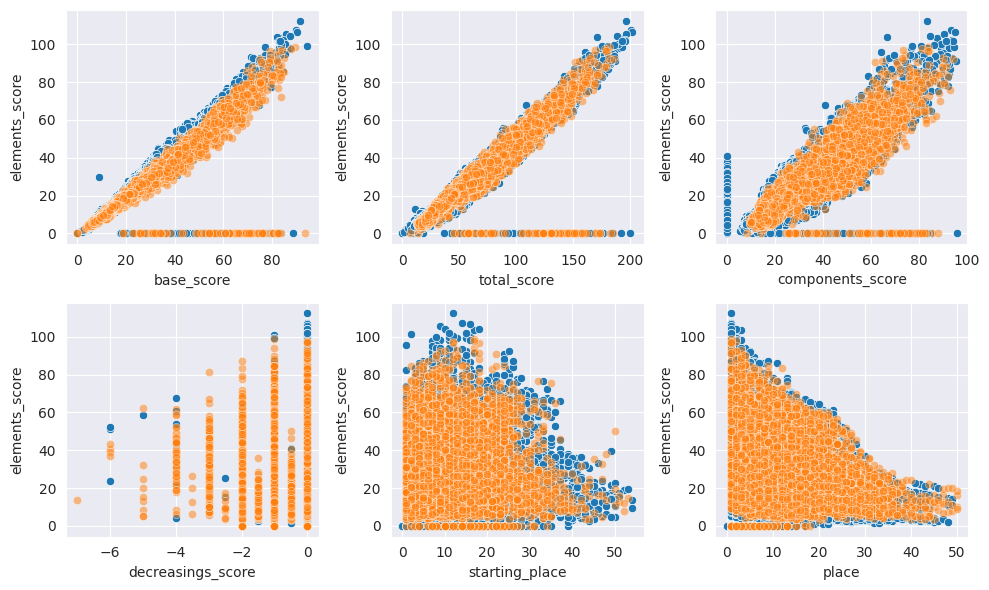

In [ ]:
# scatterplots
plt.figure(figsize=(10,6))
features = ['base_score', 'total_score', 'components_score',
            'decreasings_score', 'starting_place', 'place']

for i,col in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(x=col, y='elements_score',
                    data=t_scrs.query('~errors.str.contains("F")'))
    sns.scatterplot(x=col, y='elements_score',
                    data=t_scrs.query('errors.str.contains("F")'),
                    alpha=.5)

plt.tight_layout()
plt.show()

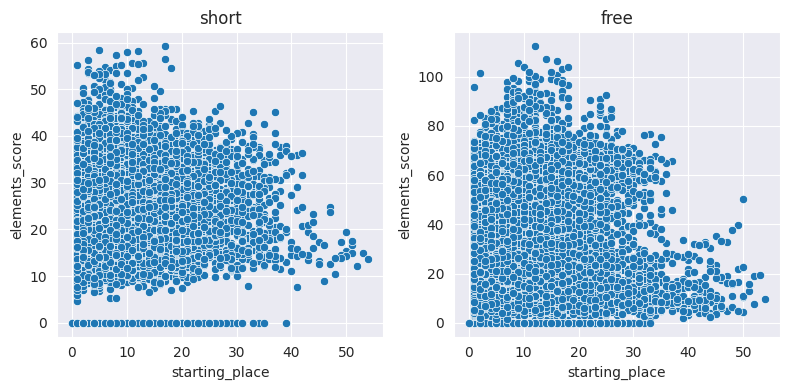

In [ ]:
# scatterplots
plt.figure(figsize=(8,4))

for i,sn in enumerate(['short', 'free']):
    plt.subplot(1, 2, i+1)
    sns.scatterplot(x='starting_place', y='elements_score',
                    data=t_scrs[
                        (t_scrs['segment_name'].notna()) &
                        (t_scrs['segment_name'].str.contains(sn))
                        ])
    plt.title(sn)

plt.tight_layout()
plt.show()

In [ ]:
# Desctiptive satatistics for number of starting places in short segment
t_scrs.query('segment_name == "short"').groupby('tournament_id')['starting_place'].max().describe()

count    133.0000
mean      24.1805
std        9.4491
min        7.0000
25%       18.0000
50%       24.0000
75%       29.0000
max       54.0000
Name: starting_place, dtype: float64

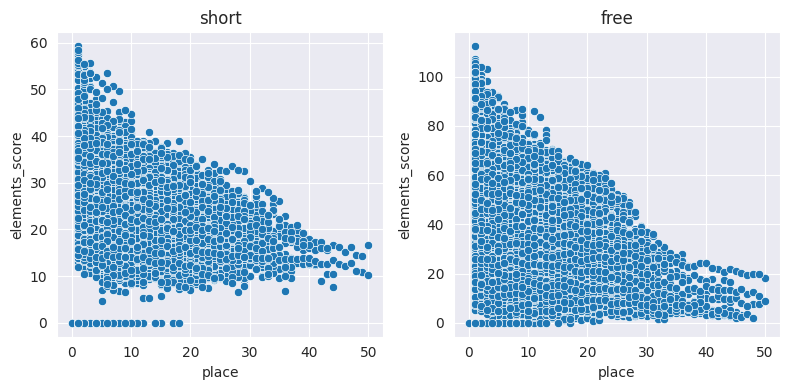

In [ ]:
# scatterplots
plt.figure(figsize=(8,4))

for i,sn in enumerate(['short', 'free']):
    plt.subplot(1, 2, i+1)
    sns.scatterplot(x='place', y='elements_score',
                    data=t_scrs[
                        (t_scrs['segment_name'].notna()) &
                        (t_scrs['segment_name'].str.contains(sn))
                        ])
    plt.title(sn)

plt.tight_layout()
plt.show()

Кажется, что наличие/отсутвие падения в выступлении принципиально не влияет на оценку за технику. Порядок выступления может влиять на оценку - ситается, что оценка выше у выступающих позже. В короткой программе порядок определяется жеребъевкой, в наших данных мы точно не знаем, является ли стартовое место в короткой программе также и порядковым номером выступления. Видно, что в целом у самых высоких оценок как правило начальное место ниже (тут хорошо бы разделить на количество участников), в произвольной программе, где начальное место - результат короткой, тенденция намного менее выражена. Стоит делать поправку на количество - зачастую их меньше 30, чем меньше участников, тем можно предположить, что ниже уровень соревнований, а значит и уровень спортсменов.
Логично, что более прямо с оценкой за технику связано место, которое получил спортсмен после выступления, странно, что у 1ых мест большой разброс в оценках - это опять же может говорить о разных уровнях соревнований. Можно взять для предсказания выступления спортсмена место, которое он занял после конкрутной программы в предыдущем турнире.

**Вывод**

В данном датасете содержатся информация о 21301 выступлении разных спортсменов на 142 турнирах, имеющихся в датасете tournaments. Без учета id выступления - есть дубликаты, пока не будем их удалять, возможно там разные элементы. В оценках есть нулевые значения, по распределению базовой стоимости программы видно, что есть более "дешевые" и более "дорогие программы", как и оценки за техническое исполнение - есть кластер более высоких и более большой кластер более низких оценок, что, соотнося с базовыми оценками за элементы, может говорить о более частом выполнении более простых элементов, а более сложных с ошибками. Наличие кластера низких оценок в общей оценке за турнир может говорить о том, что часть спортсменов выполнили только короткую программу и не были квалифицированы на произвольную (либо у нас нет данных).
Снижения (дедукции, decreasings_score) даются за потерю элемента костюма, выполнение запрещенного элемента и тд, для большинства выступлений их нет, но есть и значения -7.  Всего в турнирах 50 мест, однако для большинства соревнований мест не больше 30. Начальное дается жеребъевкой (от 0 до 54, но мы не знаем точно соответствует ли этот номер порядку выступления спортсмен), после короткой программы место присваивается по ее рузультатам.
Для предсказания выступления спортсменов вероятно имеет смысл взять место, присвоенное после выступления в определенной программе из предыдущего турнира.




### tournament_scores
В данном датасете дана информация по качеству исполнения различных элементов во время выступления. Есть три типа элементов - прыжки, вращения и шаги, они могут быть разных типов и уровней сложности. Помимо этого дана базовая стоимость элемента (с учетом качества его выполнения), субъективная средняя оценка судий и суммарная оценка.

In [ ]:
trnt_scrs = data['tournament_scores']
trnt_scrs = trnt_scrs.rename(columns={'base_score': 'element_base_score'})
trnt_scrs.head(20)

,id,total_score_id,title,decrease,element_base_score,goe,avg_score
0,1,1,2A,NaN,3.30,0.66,3.96
1,2,1,3F+3Lo,NaN,10.20,-0.11,10.09
2,3,1,3Lz,NaN,0.00,-1.30,5.19
3,4,1,CCoSp4,NaN,3.50,0.56,4.06
4,5,1,FCSp4,NaN,3.20,0.64,3.84
5,6,1,LSp4,NaN,2.70,0.49,3.19
6,7,1,StSq2,NaN,2.60,0.26,2.86
7,8,8,2A,NaN,3.30,0.53,3.83
8,9,8,3F,NaN,0.00,0.42,6.25
9,10,8,3Fq+3Loq,q,10.20,-1.91,8.29


В колонках с названиями элементов и ошибок заменим сразу возможные кириллические символы на латинские и удалим возможные точки

In [ ]:
# Replace cyrillic characters with latin
for col in ['title', 'decrease']:
    trnt_scrs[col] = trnt_scrs[col].map(lambda x: replace_cyrillic_latin(x, translate='cyrillic_latin'))
    trnt_scrs[col] = trnt_scrs[col].str.replace('\.', '', regex=True)

Проверим все ли выступления, детализированные в данном датасете, есть в таблице выступлений

In [ ]:
print('Все id есть в таблице total_scores?')
set(t_scrs['total_score_id']) == set(trnt_scrs['total_score_id'])

Все id есть в таблице total_scores?


True

В данном датасете пропущенные значения есть только в колонке с данными о снижениях - вероятно, снижений не было или данные не были указаны.

#### title

Рассмотрим, какие есть элементы и особенности указания ошибок в них.

In [ ]:
trnt_scrs['title'].sample(20)

30426        2Lz+2Lo<
81944             3F<
95049           FSSp3
35090         2Lz+2Lo
66026           ChSq1
171385    2Lz+2Loq+2T
26307              2A
141015          3F!<<
31555              2T
166751            1Lz
40050             3Lz
44020              2A
67262             2T<
113716             1A
79981             2Aq
17869           3T+2T
124287            3S<
58159         3Lzq+2T
123026             2S
141385             1A
Name: title, dtype: object

**Прыжки**<br>
В записи элементов для прыжков сначала идет цифра 1-4 (иногда нет, когда вероятно прыжок одинарный), отражающая количество оборотов, потом название прыжка (Т - тулуп, S - сальхов, Lo - риттбергер, Eu - ойлер, F - флип, Lz - лутц, А - аксель), потом ошибка, расшифровку можно взять из столбца info.
- q Прыжок приземлён в четверть (не снижается стоимость, снижается goe)
- < Недокрученный прыжок (снижается стоимость и гое)
- << Пониженный прыжок (стоимость как у прыжка на уровень меньше, снижается гое)
- '*' Недопустимый элемент (элементу как правило не защитывают стоимость, повторение прыжка, прыжок в каскажде после падения и тд)
- e Явно неправильное ребро на толчке F/Lz (снижается стоимость как <, снижается goe)
- ! Неясное ребро на толчке F/Lz (стоимость не снижается, снижается гое)

Таким образом видно, что "вес" ошибок разный и иногда более сложный прыжок с небольшим недочетом важнее более простого.

**Прыжки в каскаде/последовательности**<br>
Такие прыжки соеденины знаком +, есть отдельные обозначения:
- REP Повторение прыжка не в каскаде (прыжок мб выполнен чисто, но его стоимость снижается или он не учитывается)
- SEQ - в конце означает последовательность элементов
- COMBO - в конце не выполнен обязательный каскад в короткой программе
- SEQ/COMBO могут ставиться между элементами, когда при выполнении каскада/последовательности было падение/перенос веса тела на другую ногу

**Вращения**<br>
Есть разные типы, из разной позиции, со сменой ноги, все названия включают 'Sp' и после этого включают или нет 'B' (base) или 1-4, отражающие уровень. Если после элемента стоит V – not value значит элемент не выполнен.

**Шаги**<br>
StSq или ChSq, после которых уровень -  'B' (base) или 1-4. Если после элемента стоит V – not value значит элемент не выполнен.

**ОШИБКИ**

Для данной задачи важно определить, что считать за ошибку, а что нет. Нам важно именно выполнение элементов, а не корретное соблюдение правил программы, изучая документацию для технических специалистов и данные, решим:

- символы после прыжка, входящие в список ошибок, разделить на отдельные ошибки и учитывать
- COMBO/SEQ, когда они между прыжками считать ошибкой прыжка после которого они идут - то есть комбинация не выполнена чисто, даже если прыжок был правильный
- COMBO/SEQ в конце и после одиночного прыжка не учитывать
- REP - не учитывать
- '*' как отображение несоблюдения программы не учитывать (хотя это спорно)

In [ ]:
# replace SEQ/COMBO/REP at the end of title with ''
trnt_scrs['correct_title'] = trnt_scrs['title'].replace(regex=r'\+((SEQ|REP|SEQ\+REP|COMBO)$|REP)', value='')
trnt_scrs[trnt_scrs['title'].str.contains("COMBO")]

,id,total_score_id,title,decrease,element_base_score,goe,avg_score,correct_title
92,93,92,3F+COMBO+2T*,*,0.0,-2.65,3.18,3F+COMBO+2T*
418,419,417,3T+COMBO,F,4.2,-2.10,2.10,3T
484,485,483,3S+COMBO,F,4.3,-2.15,2.15,3S
534,535,533,3Lz!q+COMBO,!,5.9,-2.95,2.95,3Lz!q
626,627,626,2A+1Eu+COMBO+2S*,*,0.0,-0.44,3.74,2A+1Eu+COMBO+2S*
...,...,...,...,...,...,...,...,...
169345,351629,463353,1A+COMBO+1T*,*,1.1,-0.40,0.70,1A+COMBO+1T*
169388,320554,459967,3F+COMBO,NaN,5.3,-2.65,2.65,3F
169853,321022,460026,2F+COMBO,NaN,0.0,0.00,1.98,2F
169865,321034,460028,2F!q+COMBO,!F,0.0,-0.90,1.08,2F!q


In [ ]:
trnt_scrs[trnt_scrs['correct_title'].str.contains("REP")]

,id,total_score_id,title,decrease,element_base_score,goe,avg_score,correct_title


Создадим функцию для определения типа элемента

In [ ]:
def def_element_type(row):
    if 'sp' in row.lower():
        element_type = 'spin'
    elif re.search('stsq|chsq', row.lower()):
        element_type = 'step'
    elif re.search(r'\+', row):
        element_type = 'combination'
    else:
        element_type = 'jump'
    return element_type

In [ ]:
%%time
trnt_scrs['element_type'] = trnt_scrs['correct_title'].apply(def_element_type)

CPU times: user 347 ms, sys: 11 µs, total: 347 ms
Wall time: 466 ms


In [ ]:
trnt_scrs.sample(10)

,id,total_score_id,title,decrease,element_base_score,goe,avg_score,correct_title,element_type
33823,40298,8164,CCoSp4,NaN,3.5,0.70,4.20,CCoSp4,spin
2504,2447,2442,StSq2,NaN,2.6,0.52,3.12,StSq2,step
92264,195246,446239,FSSp4,NaN,3.0,0.50,3.50,FSSp4,spin
120440,160860,442616,StSq2,NaN,2.6,0.26,2.86,StSq2,step
106136,116807,333714,FCSp3,NaN,2.8,0.56,3.36,FCSp3,spin
40963,48370,9129,LSp4,NaN,2.7,0.45,3.15,LSp4,spin
18837,23281,5987,2Lz,NaN,2.1,0.14,2.24,2Lz,jump
151522,341009,461972,StSq2,NaN,2.6,0.26,2.86,StSq2,step
92135,103358,45460,CSSp4,NaN,3.0,0.70,3.70,CSSp4,spin
115392,154570,441816,LSp4,NaN,2.7,0.36,3.06,LSp4,spin


Создадим функцию для разделения названия элемента на части - элемент, ошибки

In [ ]:
def parse_title(row):
    if re.search('sp|stsq|chsq', row.lower()):
        elements = [re.sub(r'V?\*?$', '', row)]
        match = re.search(r'V?\*?$', row)[0]
        note = [match[0] if match else '0']
    else:
        jumps = 'T|S|Lo|Eu|F|Lz|A'
        errors = 'q|b|<|e|*|!|F'
        pattern_el = f'([1-4]?(?:{jumps}))(?:\+|[{errors}]+|$)'
        elements = re.compile(pattern_el).findall(row)
        pattern_n = f'[1-4]?(?:{jumps})([{errors}]*(?:\\+COMBO|\\+SEQ)?|[{errors}]*)(?:\\+|$)'
        note = re.compile(pattern_n).findall(row)
        note = [n if n else '0' for n in note]

    return elements, note

In [ ]:
%%time
trnt_scrs[['elements', 'note']] = trnt_scrs['correct_title'].apply(lambda row: pd.Series(parse_title(row)))

CPU times: user 33.5 s, sys: 403 ms, total: 33.9 s
Wall time: 42.7 s


In [ ]:
trnt_scrs.sample(20)

,id,total_score_id,title,decrease,element_base_score,goe,avg_score,correct_title,element_type,elements,note
143833,275358,454907,2F,NaN,0.00,0.12,2.10,2F,jump,[2F],[0]
105334,199464,446747,StSq2,NaN,2.60,0.26,2.86,StSq2,step,[StSq2],[0]
139347,337546,461508,CCoSp3,NaN,3.00,0.00,3.00,CCoSp3,spin,[CCoSp3],[0]
48687,56984,10142,3S<<,F,0.00,-0.65,0.78,3S<<,jump,[3S],[<<]
77799,226341,450279,CCoSp3,NaN,3.00,0.30,3.30,CCoSp3,spin,[CCoSp3],[0]
123407,211462,448261,2Fq+2Loq,q,0.00,-0.36,3.49,2Fq+2Loq,combination,"[2F, 2Lo]","[q, q]"
171680,322775,460249,CSSp2,NaN,2.30,0.00,2.30,CSSp2,spin,[CSSp2],[0]
142850,339063,461710,2A,NaN,3.30,0.11,3.41,2A,jump,[2A],[0]
134653,235035,451481,3T,NaN,4.20,0.28,4.48,3T,jump,[3T],[0]
112490,186452,445089,3Lz+3T,NaN,10.10,1.18,11.28,3Lz+3T,combination,"[3Lz, 3T]","[0, 0]"


In [ ]:
# Ensure the lists are of equal length in each row
all(trnt_scrs.apply(lambda row: len(row['elements']) == len(row['note']), axis=1))

True

#### decrease

Здесь также есть отметки о выполнении каждого элемента + было ли падение + были ли бонусы

- F Падение в элементе
- nU Нет базовой позиции 'стоя'
- nC Нет базовой позиции 'либела'
- nS Нет базовой позиции 'волчок'
- nF Нет смены ноги
- nB Нет базовой позиции на одной из ног

- x Надбавка за прыжки во второй половине программы (10%)
- B Элемент получил бонус@@@Бонусных баллов: ...

Посмотрим, каких элементов из decrease нет в созданном списке ошибок

In [ ]:
# Check if decrease value is not in note list
trnt_scrs[trnt_scrs['decrease'].notna()][~trnt_scrs[trnt_scrs['decrease'].notna()].apply(
    lambda row: set(row['decrease']).issubset(''.join(row['note'])), axis=1)]

,id,total_score_id,title,decrease,element_base_score,goe,avg_score,correct_title,element_type,elements,note
59,60,57,CCoSp3V,nS,2.25,0.08,2.33,CCoSp3V,spin,[CCoSp3],[V]
63,64,64,2A,F,0.00,-1.65,1.98,2A,jump,[2A],[0]
64,65,64,3Lo<<,F,1.70,-0.85,0.85,3Lo<<,jump,[3Lo],[<<]
100,101,99,3F+3T<,F,0.00,-2.47,7.06,3F+3T<,combination,"[3F, 3T]","[0, <]"
103,104,99,3Lzq,F,5.90,-2.95,2.95,3Lzq,jump,[3Lz],[q]
...,...,...,...,...,...,...,...,...,...,...,...
172119,351978,463403,CCoSp2V,nC,1.88,0.19,2.07,CCoSp2V,spin,[CCoSp2],[V]
172129,351927,463396,2Lo<,F,1.36,-0.68,0.68,2Lo<,jump,[2Lo],[<]
172133,351988,463404,2S,F,1.30,-0.65,0.65,2S,jump,[2S],[0]
172136,351991,463405,2T<<,F,0.40,-0.20,0.20,2T<<,jump,[2T],[<<]


In [ ]:
# which decrease values are not in note lists
trnt_scrs[trnt_scrs['decrease'].notna()][~trnt_scrs[trnt_scrs['decrease'].notna()].apply(
    lambda row: set(row['decrease']).issubset(''.join(row['note'])), axis=1)].decrease.value_counts()

decrease
F      9897
nS     1038
B       497
nC      469
nU      167
!F      164
F*       81
nF       22
*        13
b        11
nB        3
!         3
nS*       2
q         2
<*        2
qF        2
FF        2
f         2
!F*       2
<         1
e         1
f*        1
FnU       1
!*        1
<F        1
<<        1
Name: count, dtype: int64

Кажется, что для большинства случаев ошибки, указанные в decrease, учтены после элемента, дополнительно указано падение и конкретные ошибки вращений. Посмотрим, при каких из этих ошибок goe больше нуля.

In [ ]:
print('Какие ошибки не критичны')
trnt_scrs[trnt_scrs['decrease'].notna()][~trnt_scrs[trnt_scrs['decrease'].notna()].apply(
    lambda row: set(row['decrease']).issubset(''.join(row['note'])), axis=1)].query('goe>0').decrease.value_counts()

Какие ошибки не критичны


decrease
nS    753
B     494
nC    270
nU     98
b      11
nF      5
nB      1
!*      1
q       1
!       1
Name: count, dtype: int64

In [ ]:
print('Медианное гое за ошибки во вращении')
trnt_scrs.query('decrease in ["nS", "nC", "nU"]').groupby('decrease').goe.median()

Медианное гое за ошибки во вращении


decrease
nC    0.08
nS    0.18
nU    0.10
Name: goe, dtype: float64

В основном это ошибки вращений, при них примерно одинаковое goe - оставим ошибки вращения V, не будем детализировать.

Посмотрим, какие есть ошибки в комбинациях, не учтенные в названии элементов.

In [ ]:
print('Ошибки в комбинациях, не учтенные в note')
trnt_scrs[trnt_scrs['decrease'].notna()][~trnt_scrs[trnt_scrs['decrease'].notna()].apply(
    lambda row: set(row['decrease']).issubset(''.join(row['note'])), axis=1)].query('element_type=="combination"').decrease.value_counts()

Ошибки в комбинациях, не учтенные в note


decrease
F     1165
B       54
F*      29
!F      25
*        5
q        2
<*       2
!        2
<F       1
qF       1
!*       1
f        1
<        1
<<       1
Name: count, dtype: int64

Таким образом ошибки в decrease - это в основном падения и бонусы, отделим их в отдельный столбец, а остальное - в другой.

In [ ]:
def parse_decrease(row):
    if pd.isna(row):
        return row  # Return NaN unchanged
    pattern = r'(?<!n)[FfBb]'
    matches = re.search(pattern, row)
    if matches:
        fall_bonus = matches[0]
        decrease_error = re.sub(pattern, '', row)
        decrease_error = decrease_error if decrease_error else '0'
    else:
        fall_bonus = '0'
        decrease_error = row
    return fall_bonus, decrease_error

In [ ]:
# create new columns
trnt_scrs[['fall_bonus', 'decrease_error']] = trnt_scrs['decrease'].apply(lambda row: pd.Series(parse_decrease(row)))
trnt_scrs[['fall_bonus', 'decrease_error']] = trnt_scrs[['fall_bonus', 'decrease_error']].fillna('0')

In [ ]:
trnt_scrs.query('decrease.notna()').sample(20)

,id,total_score_id,title,decrease,element_base_score,goe,avg_score,correct_title,element_type,elements,note,fall_bonus,decrease_error
96544,197316,446475,3F!<+REP,F,2.97,-2.12,0.85,3F!<,jump,[3F],[!<],F,0
377,378,374,3Sq+2Tq,q,5.60,-0.86,4.74,3Sq+2Tq,combination,"[3S, 2T]","[q, q]",0,q
131879,220560,449490,2Lo<,<,1.36,-0.32,1.04,2Lo<,jump,[2Lo],[<],0,<
62422,71641,12793,2Lz!<<,F,0.60,-0.30,0.30,2Lz!<<,jump,[2Lz],[!<<],F,0
16787,20747,5686,2Aq+1Eu+2F,q,5.60,-0.40,5.20,2Aq+1Eu+2F,combination,"[2A, 1Eu, 2F]","[q, 0, 0]",0,q
135429,239362,451852,3S<+2T,<,4.74,-0.69,4.05,3S<+2T,combination,"[3S, 2T]","[<, 0]",0,<
158659,343736,462332,2Aq+1Eu+2S,q,0.00,-0.88,4.73,2Aq+1Eu+2S,combination,"[2A, 1Eu, 2S]","[q, 0, 0]",0,q
54373,63346,11725,3Lzq+3T<,<,9.26,-2.36,6.90,3Lzq+3T<,combination,"[3Lz, 3T]","[q, <]",0,<
163191,308341,458388,3Lz!,!,5.90,-0.20,5.70,3Lz!,jump,[3Lz],[!],0,!
164908,310742,458690,3Lz<,F,4.72,-2.36,2.36,3Lz<,jump,[3Lz],[<],F,0


Посмотрим, когда выделенные из decrease ошибки не входят в список ошибок note

In [ ]:
(trnt_scrs[~trnt_scrs.apply(
    lambda row: set(row['decrease_error']).issubset(''.join(row['note'])),
    axis=1)]
    .query('decrease_error != "0" and element_type !="spin"'))

,id,total_score_id,title,decrease,element_base_score,goe,avg_score,correct_title,element_type,elements,note,fall_bonus,decrease_error
673,674,672,3S+COMBO+2T,*,5.60,-2.15,3.45,3S+COMBO+2T,combination,"[3S, 2T]","[+COMBO, 0]",0,*
4346,4674,3808,A,*,0.00,0.00,0.00,A,jump,[A],[0],0,*
11449,14346,4929,2A<+1Eu+2F,q,0.00,-0.37,5.06,2A<+1Eu+2F,combination,"[2A, 1Eu, 2F]","[<, 0, 0]",0,q
33953,223385,449859,2S<+COMBO+1A,<*,2.14,-0.40,1.74,2S<+COMBO+1A,combination,"[2S, 1A]","[<+COMBO, 0]",0,<*
46418,54614,9880,2Fe+2T<,!,2.48,-0.58,1.90,2Fe+2T<,combination,"[2F, 2T]","[e, <]",0,!
51158,59709,11109,2Loq+SEQ+1A,*,2.80,-0.57,2.23,2Loq+SEQ+1A,combination,"[2Lo, 1A]","[q+SEQ, 0]",0,*
81853,94007,29588,3Lz!+1Eu+3S,!*,0.00,0.59,12.36,3Lz!+1Eu+3S,combination,"[3Lz, 1Eu, 3S]","[!, 0, 0]",0,!*
123644,336102,461308,1F+1Lo,!,1.00,-0.05,0.95,1F+1Lo,combination,"[1F, 1Lo]","[0, 0]",0,!
123901,336314,461340,1Lo+1A+SEQ,<,1.60,-0.22,1.38,1Lo+1A,combination,"[1Lo, 1A]","[0, 0]",0,<
124397,212335,448381,3Lo<+2T,<*,0.00,-1.31,4.43,3Lo<+2T,combination,"[3Lo, 2T]","[<, 0]",0,<*


Примем решение учитывать ошибки из note и падения, ошибки из decrease отражены в note.

In [ ]:
print('Количество выступлений с падениями')
res = trnt_scrs.groupby('total_score_id', as_index=False).agg({'fall_bonus': lambda x: ','.join(x)})
len(res.query('fall_bonus.str.contains("F")'))

Количество выступлений с падениями


7479

In [ ]:
print('Количество выступлений с падениями в total_scores')
len(t_scrs.query('errors.str.contains("(?<!n)F", regex=True)'))

Количество выступлений с падениями в total_scores


6902

In [ ]:
print('Количество выступлений с надбавками')
res = trnt_scrs.groupby('total_score_id', as_index=False).agg({'fall_bonus': lambda x: ','.join(x)})
len(res.query('fall_bonus.str.contains("b")'))

Количество выступлений с надбавками


8

In [ ]:
print('Количество выступлений с надбавками в total_scores')
len(t_scrs.query('bonuses.str.contains("x", regex=True)'))

Количество выступлений с надбавками в total_scores


15339

Количество выступлений с падениями в данном датасете больше, чем в общем, можно предположить, что все падения, указанные в общем датасете, отражены в данном, в отличие от надбавок за выступление во второй части программы.

#### scores
посмотрим на оценки и базовую стоимость элементов

In [ ]:
print('\033[1m\nКоличество значений = 0')
(trnt_scrs[['decrease', 'element_base_score', 'goe', 'avg_score']]==0).sum()


Количество значений = 0


decrease                  0
element_base_score    33791
goe                   14459
avg_score              4031
dtype: int64

- **Базовая стоимость элемента** мб равна нулю, когда элемент не учитывают (он выполнен вне программы, повторен), а также просто это поле могло быть не заполнено. Кроме этого, стоит учитывать, что базовая стоимость элементов может меняться в зависимости от сезона. При  наличии серьезных ошибок ('<', '<<', 'e') снижается (значения без снижения и со снижением даются в таблицах).
- **goe** - grade of execution, субъективная оценка судьями выполнения элемента, учитывающая падения, грубые ошибки, изменяющие базовую стоимость элемента ('<', '<<', 'e') и погрешности, не влияющие на базовую стоимость ('q', '!'). Правила рассчета зависят от количества судий и также могут менятся в зависимости от сезона. В целом это усеченное среднее, значения отрицательны при ошибках, положительны при достоинствах выполнения. Значения могут быть равны нулю, если исполнение "ни убавить, ни прибавить", или ошибки компенсируют достоинства.
- **общая оценка** складывается из базовой стоимости и goe и вполне может быть равной 0.

In [ ]:
print('Если общая оценка = 0, стоимость и goe тоже?')
((trnt_scrs['avg_score']==0).sum() ==
 ((trnt_scrs['avg_score']==0) &
  (trnt_scrs['element_base_score']==0) &
  (trnt_scrs['goe']==0)).sum())

Если общая оценка = 0, стоимость и goe тоже?


True

In [ ]:
print('Количество элементов с 0 стоимостью и 0 goe')
(((trnt_scrs['avg_score']!=0) &
  (trnt_scrs['element_base_score']==0) &
  (trnt_scrs['goe']==0)).sum())

Количество элементов с 0 стоимостью и 0 goe


2313

In [ ]:
print('Количество элементов с не0 стоимостью и 0 goe')
(((trnt_scrs['avg_score']!=0) &
  (trnt_scrs['element_base_score']!=0) &
  (trnt_scrs['avg_score']!= trnt_scrs['element_base_score']) &
  (trnt_scrs['goe']==0)).sum())

Количество элементов с не0 стоимостью и 0 goe


0

In [ ]:
print('Количество элементов с 0 стоимостью и не0 goe')
(((trnt_scrs['avg_score']!=0) &
  (trnt_scrs['element_base_score']==0) &
  (trnt_scrs['goe']!=0)).sum())

Количество элементов с 0 стоимостью и не0 goe


27447

Таким образом, есть много случаев, когда стоимость элемента не была указана, в случаях, когда она нулевая "специально" (элемент не защитан) - общая оценка также нулевая. Восстановить базовую стоимость, когда она не указана,  можно вычитая goe из общей оценки.
Но стоит учитывать, что базовая стоимость элементов может меняться в зависимости от сезона. Для оценки относительной стоимости элементов и унификации можно взять базовые стоимости для всех элементов из одного сезона, указанные в специальных таблицах.

- goe

Есть, случаи, когда goe "истинно" нулевое - тогда общая оценка равна базовой стоимости, но когда общая оценка не нулевая, а базовая стоимость нулевая (не заполнена)- мы точно не знаем, гое не заполнено или равно 0. Теоретически, при наличии ошибок goe должно быть скорее отрицательным, однако, можно предположить, разность мнений судий и достоинства исполнения, которые перекроют ошибки.

In [ ]:
print('Когда есть ошибки, но goe положительно')
trnt_scrs.query('decrease.notna() and goe > 0').decrease.value_counts()

Когда есть ошибки, но goe положительно


decrease
nS    753
B     494
!     470
nC    270
nU     98
*      90
q      26
b      11
nF      5
<       2
e       1
nB      1
!*      1
Name: count, dtype: int64

Тут некритичные ошибки и бонусы, падений нет.

In [ ]:
print('Ошибки, при низком goe')
trnt_scrs.query('goe < -2').decrease.value_counts()

Ошибки, при низком goe


decrease
F      3419
<       287
q       234
<<      132
*        91
!        81
!F       75
e        13
F*        3
q*        2
f         2
<<*       1
<*        1
!*        1
FF        1
qF        1
Name: count, dtype: int64

В большинстве случаев goe отрицательно при наличии падений - будем учитывать этот фактор наряду с ошибками выполнения элемента.

Исходя из того, что бонус b обычно стоит в конце, и элементы могут иметь нулевую базовую стоимость, предположим, что элементы в выступлении идут по порядку. Присвоим им последовательные номера

In [ ]:
# add new column with element order
trnt_scrs['elements_order'] = (trnt_scrs.groupby('total_score_id').cumcount() + 1).astype(int)
trnt_scrs.head(20)

,id,total_score_id,title,decrease,element_base_score,goe,avg_score,correct_title,element_type,elements,note,fall_bonus,decrease_error,elements_order
0,1,1,2A,NaN,3.30,0.66,3.96,2A,jump,[2A],[0],0,0,1
1,2,1,3F+3Lo,NaN,10.20,-0.11,10.09,3F+3Lo,combination,"[3F, 3Lo]","[0, 0]",0,0,2
2,3,1,3Lz,NaN,0.00,-1.30,5.19,3Lz,jump,[3Lz],[0],0,0,3
3,4,1,CCoSp4,NaN,3.50,0.56,4.06,CCoSp4,spin,[CCoSp4],[0],0,0,4
4,5,1,FCSp4,NaN,3.20,0.64,3.84,FCSp4,spin,[FCSp4],[0],0,0,5
5,6,1,LSp4,NaN,2.70,0.49,3.19,LSp4,spin,[LSp4],[0],0,0,6
6,7,1,StSq2,NaN,2.60,0.26,2.86,StSq2,step,[StSq2],[0],0,0,7
7,8,8,2A,NaN,3.30,0.53,3.83,2A,jump,[2A],[0],0,0,1
8,9,8,3F,NaN,0.00,0.42,6.25,3F,jump,[3F],[0],0,0,2
9,10,8,3Fq+3Loq,q,10.20,-1.91,8.29,3Fq+3Loq,combination,"[3F, 3Lo]","[q, q]",0,q,3


#### Long format

Создадим датафрейм без лишней информации и разобъем комбинации на отдельные прыжки, однако тут стоит понимать, что **всем прыжкам присвоятся одинаковые оценки и  goe**, что некорректно. goe в комбинации считается для самого сложного прыжка, то есть остальным стоит указывать 0. Базовую же стоимость можно взять из таблиц, с учетом ошибок в прыжке. Однако на данный момент оставим, как есть.

In [ ]:
df_elements = trnt_scrs.drop(['id', 'correct_title', 'decrease', 'decrease_error'], axis=1)
df_elements

,total_score_id,title,element_base_score,goe,avg_score,element_type,elements,note,fall_bonus,elements_order
0,1,2A,3.3,0.66,3.96,jump,[2A],[0],0,1
1,1,3F+3Lo,10.2,-0.11,10.09,combination,"[3F, 3Lo]","[0, 0]",0,2
2,1,3Lz,0.0,-1.30,5.19,jump,[3Lz],[0],0,3
3,1,CCoSp4,3.5,0.56,4.06,spin,[CCoSp4],[0],0,4
4,1,FCSp4,3.2,0.64,3.84,spin,[FCSp4],[0],0,5
...,...,...,...,...,...,...,...,...,...,...
172153,463407,CCoSp3,3.0,0.60,3.60,spin,[CCoSp3],[0],0,4
172154,463407,2Lz,2.1,0.00,2.10,jump,[2Lz],[0],0,5
172155,463407,2Lo,1.7,0.23,1.93,jump,[2Lo],[0],0,6
172156,463407,StSq2,2.6,0.52,3.12,step,[StSq2],[0],0,7


In [ ]:
# Explode the DataFrame for each list column
df_elements = df_elements.set_index(list(df_elements.drop(['elements', 'note'], axis=1))).apply(pd.Series.explode).reset_index()
df_elements.head(20)

,total_score_id,title,element_base_score,goe,avg_score,element_type,fall_bonus,elements_order,elements,note
0,1,2A,3.30,0.66,3.96,jump,0,1,2A,0
1,1,3F+3Lo,10.20,-0.11,10.09,combination,0,2,3F,0
2,1,3F+3Lo,10.20,-0.11,10.09,combination,0,2,3Lo,0
3,1,3Lz,0.00,-1.30,5.19,jump,0,3,3Lz,0
4,1,CCoSp4,3.50,0.56,4.06,spin,0,4,CCoSp4,0
5,1,FCSp4,3.20,0.64,3.84,spin,0,5,FCSp4,0
6,1,LSp4,2.70,0.49,3.19,spin,0,6,LSp4,0
7,1,StSq2,2.60,0.26,2.86,step,0,7,StSq2,0
8,8,2A,3.30,0.53,3.83,jump,0,1,2A,0
9,8,3F,0.00,0.42,6.25,jump,0,2,3F,0


In [ ]:
print('Какие есть ошибки')
df_elements.note.value_counts()

Какие есть ошибки


note
0            172322
<             13992
q              8597
<<             6942
!              3758
*              2516
V              2212
e               815
!<              802
!q              516
<*              350
<<*             289
!<<             229
q*              211
e<              162
+COMBO          150
!*              105
+SEQ             95
eq               95
e<<              81
<<+COMBO         56
<+SEQ            49
<+COMBO          41
q+SEQ            27
<<+SEQ           26
q+COMBO          22
e*               20
!<*              14
!q*              12
*+COMBO           9
!+COMBO           6
!<<*              5
e<*               4
<<*+COMBO         3
!<+COMBO          3
!q+COMBO          3
eq+COMBO          2
!<<+COMBO         2
e+COMBO           2
<*+COMBO          1
!<<+SEQ           1
e+SEQ             1
!<+SEQ            1
*<                1
e<<+SEQ           1
!+SEQ             1
q*+COMBO          1
*+SEQ             1
Name: count, dtype: int64

In [ ]:
print('Ошибки без учета "*"')
df_elements['note'].str.replace('*', '').value_counts()

Ошибки без учета "*"


note
0            172322
<             14343
q              8808
<<             7231
!              3863
               2516
V              2212
e               835
!<              816
!q              528
!<<             234
e<              166
+COMBO          159
+SEQ             96
eq               95
e<<              81
<<+COMBO         59
<+SEQ            49
<+COMBO          42
q+SEQ            27
<<+SEQ           26
q+COMBO          23
!+COMBO           6
!q+COMBO          3
!<+COMBO          3
e+COMBO           2
!<<+COMBO         2
eq+COMBO          2
!<<+SEQ           1
e+SEQ             1
!<+SEQ            1
e<<+SEQ           1
!+SEQ             1
Name: count, dtype: int64

Мы решили не учитывать звездочку в качестве ошибки, так как зачастую ее ставят прыжку, не соответсвующему программе/повторному/ после падения в комбинации, но сам прыжок может быть исполнен корректно.

In [ ]:
# replace * with ''
df_elements['note'] = df_elements['note'].str.replace('*', '')
df_elements['note'] = df_elements['note'].replace('', '0')
df_elements['note'].str.contains('\*').sum()

0

In [ ]:
print('Самое низкое goe при ошибках:')
df_elements.query('goe<-3')[['note', 'fall_bonus']].value_counts()

Самое низкое goe при ошибках:


note     fall_bonus
<        F             227
0        F             213
q        F             136
0        0              56
<        0              44
q        0              36
!<       F               4
q+COMBO  0               3
<<       0               2
!        0               1
e        0               1
0        f               1
+COMBO   F               1
         0               1
!q       F               1
         0               1
q+SEQ    0               1
Name: count, dtype: int64

Самое низкое goe как правило у прыжков с падением и недокрутом, странно, что оно есть и у элементов без отметки ошибки, можно предположить, что ошибка не была указана.

В списках ошибок у одного элемента мб больше одной ошибки и они идут рядом.Разделим их.

In [ ]:
def split_note(row):
    errors = 'q|<<|<|!|V|e|\+COMBO|\+SEQ'
    matches = re.findall(errors, row)
    return matches

In [ ]:
# separate errors
df_elements['note_list'] = df_elements['note'].apply(split_note)

In [ ]:
df_elements.query('note!="0"').sample(20)

,total_score_id,title,element_base_score,goe,avg_score,element_type,fall_bonus,elements_order,elements,note,note_list
173379,463618,3S<+2T,0.00,-0.69,4.52,combination,0,7,3S,<,[<]
155938,448441,2Lzq,2.10,-0.14,1.96,jump,0,6,2Lz,q,[q]
163384,449247,2S+2Loq,3.00,-0.17,2.83,combination,0,1,2Lo,q,[q]
64886,11228,2F+2Tq,3.10,-0.36,2.74,combination,0,5,2T,q,[q]
82765,13333,2S<+1A,2.14,-0.22,1.92,combination,0,2,2S,<,[<]
200163,457992,2F<<+1Aq+SEQ,1.60,-0.55,1.05,combination,F,5,1A,q,[q]
161297,449031,2S+2Loq+1Aq+SEQ,4.10,-0.51,3.59,combination,0,5,2Lo,q,[q]
67017,11467,2Lz+2Loq,0.00,-0.42,3.76,combination,0,5,2Lo,q,[q]
173324,461502,2F<+1A+SEQ,2.54,-0.38,2.16,combination,0,2,2F,<,[<]
100221,3535,3Lz<+2A+SEQ,8.02,-0.78,7.24,combination,0,4,3Lz,<,[<]


Значения ошибок перенесем в колонки, добавим также отдельные колонки для бонусов и падений.

In [ ]:
# Identify all unique values across all lists
unique_values = set(value for sublist in df_elements['note_list'] for value in sublist)
# Create new columns for each unique value
for value in unique_values:
    df_elements[value] = df_elements['note_list'].apply(lambda x: 1 if value in x else 0).astype(int)

In [ ]:
# rename columns
df_elements=df_elements.rename(columns={'<': 'ur', '<<': 'uur', '!': 'ue'})

In [ ]:
for value in {'F', 'B'}:
    df_elements[value] = df_elements['fall_bonus'].str.contains(value, case=False).astype(int)

In [ ]:
df_elements.query('fall_bonus=="F"')

,total_score_id,title,element_base_score,goe,avg_score,element_type,fall_bonus,elements_order,elements,note,note_list,+COMBO,q,uur,e,ur,ue,V,+SEQ,B,F
78,64,2A,0.00,-1.65,1.98,jump,F,1,2A,0,[],0,0,0,0,0,0,0,0,0,1
79,64,3Lo<<,1.70,-0.85,0.85,jump,F,2,3Lo,<<,[<<],0,0,1,0,0,0,0,0,0,1
127,99,3F+3T<,0.00,-2.47,7.06,combination,F,3,3F,0,[],0,0,0,0,0,0,0,0,0,1
128,99,3F+3T<,0.00,-2.47,7.06,combination,F,3,3T,<,[<],0,0,0,0,1,0,0,0,0,1
132,99,3Lzq,5.90,-2.95,2.95,jump,F,6,3Lz,q,[q],0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214473,463399,2F<,1.44,-0.72,0.72,jump,F,5,2F,<,[<],0,0,0,0,1,0,0,0,0,1
214519,463396,2Lo<,1.36,-0.68,0.68,jump,F,4,2Lo,<,[<],0,0,0,0,1,0,0,0,0,1
214523,463404,2S,1.30,-0.65,0.65,jump,F,6,2S,0,[],0,0,0,0,0,0,0,0,0,1
214527,463405,2T<<,0.40,-0.20,0.20,jump,F,2,2T,<<,[<<],0,0,1,0,0,0,0,0,0,1


Разделим также элемент на название и уровень. В случае базового уровня для вращений укажем 0.

In [ ]:
def split_element_level(df):
    # Extract elements and levels for jumps and combinations
    jump_comb_elements = df['elements'].str.replace(r'\d', '', regex=True)
    jump_comb_levels = df['elements'].str.extract(r'(\d)').fillna(1).astype(int)[0]

    # Extract elements and levels for steps and spins
    step_spin_elements = df['elements'].str.replace(r'((\d|B)$)', '', regex=True)
    step_spin_levels = df['elements'].str.extract(r'((\d|B)$)').fillna(0)[0].replace('B', 0).astype(int)

    # Apply np.where to conditionally assign values based on element_type
    df['element'] = np.where(df['element_type'].isin(['jump', 'combination']), jump_comb_elements, step_spin_elements)
    df['level'] = np.where(df['element_type'].isin(['jump', 'combination']), jump_comb_levels, step_spin_levels)

    return df

# Assuming df_elements is your DataFrame
df_elements = split_element_level(df_elements)

In [ ]:
df_elements.query('elements == "FCSpB"')

,total_score_id,title,element_base_score,goe,avg_score,element_type,fall_bonus,elements_order,elements,note,note_list,+COMBO,q,uur,e,ur,ue,V,+SEQ,B,F,element,level
9782,4348,FCSpB,1.6,0.03,1.63,spin,0,7,FCSpB,0,[],0,0,0,0,0,0,0,0,0,0,FCSp,0
13702,4880,FCSpB,1.6,-0.27,1.33,spin,0,4,FCSpB,0,[],0,0,0,0,0,0,0,0,0,0,FCSp,0
17572,5313,FCSpB,1.6,0.22,1.82,spin,0,6,FCSpB,0,[],0,0,0,0,0,0,0,0,0,0,FCSp,0
17937,5340,FCSpB,1.6,0.16,1.76,spin,0,8,FCSpB,0,[],0,0,0,0,0,0,0,0,0,0,FCSp,0
19782,5596,FCSpB,1.6,0.27,1.87,spin,0,6,FCSpB,0,[],0,0,0,0,0,0,0,0,0,0,FCSp,0
20146,5621,FCSpB,1.6,0.21,1.81,spin,0,8,FCSpB,0,[],0,0,0,0,0,0,0,0,0,0,FCSp,0
22877,5910,FCSpB,1.6,0.11,1.71,spin,0,5,FCSpB,0,[],0,0,0,0,0,0,0,0,0,0,FCSp,0
23927,6057,FCSpB,1.6,0.00,1.60,spin,0,5,FCSpB,0,[],0,0,0,0,0,0,0,0,0,0,FCSp,0
25742,6232,FCSpB,1.6,-0.16,1.44,spin,0,5,FCSpB,0,[],0,0,0,0,0,0,0,0,0,0,FCSp,0
26736,6341,FCSpB,1.6,-0.37,1.23,spin,0,5,FCSpB,0,[],0,0,0,0,0,0,0,0,0,0,FCSp,0


Проверим названия получившихся элементов

In [ ]:
df_elements.query('element_type == "jump"')['element'].unique()

array(['A', 'Lz', 'F', 'S', 'Lo', 'T'], dtype=object)

In [ ]:
df_elements.query('element_type == "combination"')['element'].unique()

array(['F', 'Lo', 'Lz', 'Eu', 'T', 'A', 'S'], dtype=object)

In [ ]:
df_elements.query('element_type == "step"')['element'].unique()

array(['StSq', 'ChSq'], dtype=object)

In [ ]:
df_elements.query('element_type == "spin"')['element'].unique()

array(['CCoSp', 'FCSp', 'LSp', 'FCCoSp', 'FSSp', 'CSSp', 'CSp', 'FUSp',
       'CCSp', 'FCSSp', 'SSp', 'ChSpl', 'Sp', 'CoSp', 'FLSp', 'FCoSp',
       'USp', 'FCCSp', 'FSsp'], dtype=object)

In [ ]:
# all element names to lower
df_elements['element'] = df_elements['element'].str.lower()

Посмотрим, какие элементы исполняют реже всего - для них будет сложнее построить прогноз выполнения.

**Прыжки**

In [ ]:
# number of elements
df_elements.query('element_type=="jump"').groupby('element')['level'].value_counts()

element  level
a        2        12172
         1         3878
         3         1378
f        2         5557
         3         4556
         1          568
         4           30
lo       3         5892
         2         2901
         1          467
         4           68
lz       2         5459
         3         5215
         1         2037
         4          104
s        3         4292
         2         2846
         4          325
         1          189
t        3         1696
         4          499
         2          372
         1           43
Name: count, dtype: int64

Самые редкие одиночные прыжки - одинарный тулуп (тк легкий), четверной флип и ритбергер (так как сложные). Одинарный тулуп можно убрать из предсказаний.

Посмотрим, в каких одинарных прыжках спортсмены не ошибаются.

In [ ]:
# sum of errors
df_elements['sum_errors'] = df_elements[['q', 'V', 'ur', 'e', 'ue']].sum(axis=1)
df_elements['F'] = df_elements[['+COMBO', '+SEQ', 'F']].sum(axis=1)
df_elements['F'] = df_elements['F'].clip(upper=1)
(df_elements['F'] > 1).sum()

0

In [ ]:
# % clear single jumps
(df_elements
 .query('sum_errors==0 and element_type=="jump"')
 .groupby('element')['level']
 .value_counts()
 .div(df_elements
      .query('element_type=="jump"')
      .groupby('element')['level']
      .value_counts())
 )

element  level
a        2        0.8542
         1        0.9719
         3        0.7417
f        2        0.6021
         3        0.6148
         1        0.9120
         4        0.5000
lo       3        0.7738
         2        0.7063
         1        0.9872
         4        0.5735
lz       2        0.6604
         3        0.6738
         1        0.8606
         4        0.6923
s        3        0.7036
         2        0.7656
         4        0.6123
         1        0.9947
t        3        0.7158
         4        0.6573
         2        0.7527
         1        0.9767
Name: count, dtype: float64

Почти всегда спортсмены не ошибаются в одинарных прыжках, в большинстве случаев не ошибаются в двойных и тройных.

In [ ]:
# % of falls in single jumps
(df_elements
 .query('F==1 and element_type=="jump"')
 .groupby('element')['level']
 .value_counts()
 .div(df_elements
      .query('element_type=="jump"')
      .groupby('element')['level']
      .value_counts())
 )

element  level
a        1        0.0560
         2        0.1061
         3        0.2460
f        1        0.0194
         2        0.0767
         3        0.1675
         4        0.2333
lo       1        0.0578
         2        0.1186
         3        0.1405
         4        0.2647
lz       1        0.0137
         2        0.1138
         3        0.2362
         4        0.3846
s        1        0.0423
         2        0.1367
         3        0.2206
         4        0.3323
t        1        0.0698
         2        0.1102
         3        0.2671
         4        0.3768
Name: count, dtype: float64

Самый высокий процент падений у 4F, 3Lz, 3A, 4Lo, 4S, 4T, 4Lz, а самый низкий - 1F и 1Lz.

**Прыжки в комбинациях**

In [ ]:
# number of elements
df_elements.query('element_type=="combination"').groupby('element')['level'].value_counts()

element  level
a        2         6547
         1         4861
         3          409
eu       1         3418
f        2         5219
         3         3736
         1          365
         4            1
lo       2         8185
         3         2306
         1         1861
         4            3
lz       3         6379
         2         5560
         1          213
         4           25
s        3         4274
         2         3076
         4          105
         1           77
t        2        13753
         3         7116
         1          206
         4          193
Name: count, dtype: int64

Самые редкие прыжки комбинациях - 4F, 4Lo, 4Lz, вероятно их следует убрать для прогноза.

Посмотрим, в каких прыжках  в комбинациях спортсмены не ошибаются.

In [ ]:
# % clear jumps within combinations
(df_elements
 .query('sum_errors==0 and element_type=="combination"')
 .groupby('element')['level']
 .value_counts()
 .div(df_elements
      .query('element_type=="combination"')
      .groupby('element')['level']
      .value_counts())
 )

element  level
a        1        0.9733
         2        0.8734
         3        0.8851
eu       1        1.0000
f        1        0.9370
         2        0.6214
         3        0.7115
         4           NaN
lo       1        0.9516
         2        0.6710
         3        0.7580
         4        1.0000
lz       1        0.8779
         2        0.7646
         3        0.7943
         4        0.8000
s        1        1.0000
         2        0.8017
         3        0.7335
         4        0.8762
t        1        1.0000
         2        0.9087
         3        0.7694
         4        0.8808
Name: count, dtype: float64

Спортсмены реже ошибаются в прыжках в комбинациях, посмотрим в каких.

In [ ]:
# % of errors in jumps within combinations
(df_elements
 .query('sum_errors>0 and element_type=="combination"')
 .groupby('element')['level']
 .value_counts()
 .div(df_elements
      .query('element_type=="combination"')
      .groupby('element')['level']
      .value_counts())
 )

element  level
a        1        0.0267
         2        0.1266
         3        0.1149
eu       1           NaN
f        1        0.0630
         2        0.3786
         3        0.2885
         4        1.0000
lo       1        0.0484
         2        0.3290
         3        0.2420
         4           NaN
lz       1        0.1221
         2        0.2354
         3        0.2057
         4        0.2000
s        1           NaN
         2        0.1983
         3        0.2665
         4        0.1238
t        1           NaN
         2        0.0913
         3        0.2306
         4        0.1192
Name: count, dtype: float64

Внутри комбинации спортсмены чаще ошибаются в 2F, 2Lo, 3S, 3F, всегда в 4F.

In [ ]:
# % of falls in jumps within combination
(df_elements
 .query('F==1 and element_type=="combination"')
 .groupby('element')['level']
 .value_counts()
 .div(df_elements
      .query('element_type=="combination"')
      .groupby('element')['level']
      .value_counts())
 )

element  level
a        1        0.0348
         2        0.0405
         3        0.0196
eu       1        0.0357
f        1        0.0247
         2        0.0448
         3        0.0385
         4           NaN
lo       1        0.0220
         2        0.0483
         3        0.0412
         4           NaN
lz       1        0.0469
         2        0.0412
         3        0.0417
         4           NaN
s        1        0.0390
         2        0.0514
         3        0.0468
         4        0.0095
t        1        0.0340
         2        0.0180
         3        0.0575
         4        0.0104
Name: count, dtype: float64

Самый высокий процент падений у 2Lo, 2S, 3T, а самый низкий - у 4T и 4S (но их и исполняют редко).

**Вращения**

In [ ]:
# non-frequent elements
(df_elements
 .query('element_type=="spin"')
 .groupby('element')['level']
 .value_counts()[
     df_elements
     .query('element_type=="spin"')
     .groupby('element')['level']
     .value_counts()<100
     ]
 )

element  level
ccsp     1        90
         0        56
cosp     0        92
         1        29
         2        11
csp      1        49
         2        32
         3        25
         4        24
fccosp   1        34
         0        16
fccsp    4         1
fcosp    0         3
         2         2
fcsp     0        95
fcssp    2        58
         1        41
         3        29
         4        14
         0         8
flsp     4        16
         3         8
         2         1
fusp     1         1
lsp      0        76
sp       0        88
ssp      4        59
usp      0        15
Name: count, dtype: int64

Самые редкие  вращения - CoSp2, FCCSp4, FCoSpB-1, FCSSpB, FLSp2-3, FUSp1,  вероятно их следует убрать для прогноза.

Посмотрим, в каких вращениях спортсмены не ошибаются.

In [ ]:
# % clear spins
(df_elements
 .query('sum_errors==0 and element_type=="spin"')
 .groupby('element')['level']
 .value_counts()
 .div(df_elements
      .query('element_type=="spin"')
      .groupby('element')['level']
      .value_counts())[df_elements
 .query('sum_errors==0 and element_type=="spin"')
 .groupby('element')['level']
 .value_counts()
 .div(df_elements
      .query('element_type=="spin"')
      .groupby('element')['level']
      .value_counts()) > 0.9]
 )

element  level
ccosp    3        0.9208
         4        0.9838
ccsp     0        0.9286
         1        0.9222
         2        0.9442
         3        0.9974
         4        1.0000
chspl    0        1.0000
         1        1.0000
csp      0        1.0000
         1        1.0000
         2        1.0000
         3        1.0000
         4        1.0000
cssp     0        0.9762
         1        0.9318
         2        0.9401
         3        0.9879
         4        0.9975
fccosp   0        0.9375
         4        0.9822
fccsp    4        1.0000
fcosp    0        1.0000
fcsp     0        1.0000
         1        0.9960
         2        1.0000
         3        1.0000
         4        1.0000
fcssp    3        0.9310
         4        1.0000
flsp     2        1.0000
         3        1.0000
         4        1.0000
fssp     0        1.0000
         1        0.9707
         2        0.9792
         3        0.9957
         4        0.9996
fusp     1        1.0000
lsp      0

Очень во многих вращениях спортсмены не ошибаются, вероятно не представляет большой интерес предсказание их выполнения. Посмотрим, в каких вращениях спортсмены ошибаются чаще всего.

In [ ]:
# % errors in spins
res = (df_elements
 .query('sum_errors>0 and element_type=="spin"')
 .groupby('element')['level']
 .value_counts()
 .div(df_elements
      .query('element_type=="spin"')
      .groupby('element')['level']
      .value_counts())
)

res[(res>0.1) & res.notna()]

element  level
ccosp    0        0.2253
         1        0.2641
         2        0.2454
cosp     0        0.2500
         1        0.4828
         2        0.9091
fccosp   1        0.6765
         2        0.4242
         3        0.1470
fcosp    2        1.0000
fcssp    0        0.3750
         1        0.2439
         2        0.1724
Name: count, dtype: float64

Чаще всего спортсмены ошибаются во вращениях: CoSp1, FCCoSp1-2, всегда и почти всегда в FCoSp2 и CoSp2. Вероятно, чтоит предсказывать только выполнение вращений, в которых наблюдались ошибки.

In [ ]:
# % of falls spins
res = (df_elements
 .query('F==1 and element_type=="spin"')
 .groupby('element')['level']
 .value_counts()
 .div(df_elements
      .query('element_type=="spin"')
      .groupby('element')['level']
      .value_counts())
)

res[(res>0.1) & res.notna()]

element  level
cosp     0        0.2283
         2        0.1818
fccosp   0        0.2500
fcsp     0        0.1263
fssp     0        0.1892
sp       0        0.3864
Name: count, dtype: float64

Самый высокий процент падений у вращения SpB и FCCoSp.

**Шаги**

In [ ]:
# number of elements
df_elements.query('element_type=="step"').groupby('element')['level'].value_counts()

element  level
chsq     1        8302
         0          41
stsq     2        5097
         1        2725
         0        2100
         3        1943
         4         194
Name: count, dtype: int64

Самые редкие шаги - хореографическая последовательность ChSqB и комбинация шагов StSq4.

Посмотрим, в каких шагах спортсмены не ошибаются.

In [ ]:
# % clear steps
(df_elements
 .query('sum_errors==0 and element_type=="step"')
 .groupby('element')['level']
 .value_counts()
 .div(df_elements
      .query('element_type=="step"')
      .groupby('element')['level']
      .value_counts())
 )

element  level
chsq     1        1.0
         0        1.0
stsq     2        1.0
         1        1.0
         0        1.0
         3        1.0
         4        1.0
Name: count, dtype: float64

Спортсмены не ошибаются в шагах, вероятно можно не прогнозировать их выполнение.

In [ ]:
# % of falls in steps
(df_elements
 .query('F==1 and element_type=="step"')
 .groupby('element')['level']
 .value_counts()
 .div(df_elements
      .query('element_type=="step"')
      .groupby('element')['level']
      .value_counts())
 )

element  level
chsq     0        0.0488
         1        0.0066
stsq     0        0.0195
         1        0.0147
         2        0.0067
         3        0.0036
         4        0.0103
Name: count, dtype: float64

Спортсмены практически не падают при шагах, не будем их учитывать при прогнозировании.

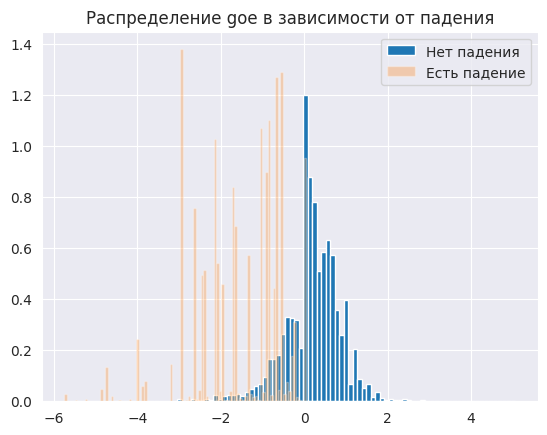

In [ ]:
# hist of goe with and without falls
df_elements.query('F==0')['goe'].hist(bins=100, density = True)
df_elements.query('F==1')['goe'].hist(bins=100, alpha=0.3, density = True)

plt.title('Распределение goe в зависимости от падения')
plt.legend(['Нет падения', 'Есть падение'])
plt.show()

**Вывод**


### Объединение данных

In [ ]:
df = t_scrs.merge(units, how='left')
df = df.merge(tournaments, how='left')

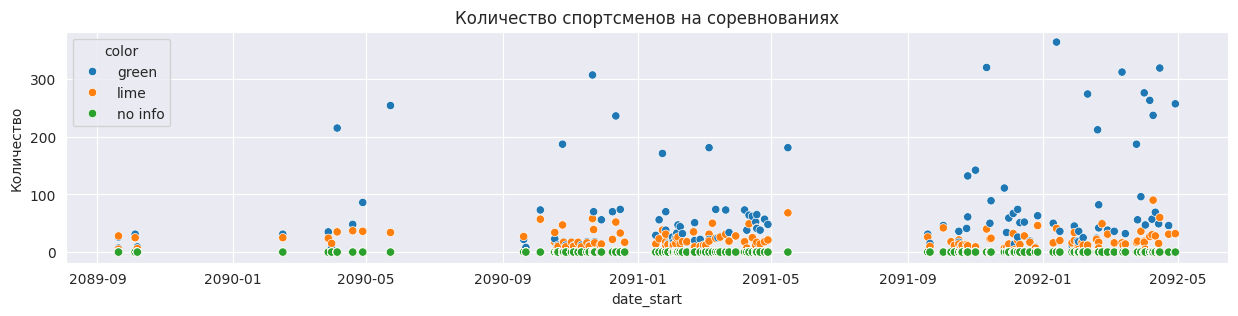

In [ ]:
# Create figure
agg_df = df.groupby(['date_start', 'tournament_id', 'color'])['unit_id'].nunique().reset_index()

plt.figure(figsize=(15, 3))
sns.scatterplot(x='date_start', y='unit_id', data=agg_df, hue='color')

#plt.xlabel(None)
plt.ylabel('Количество')
plt.title('Количество спортсменов на соревнованиях')
plt.show()

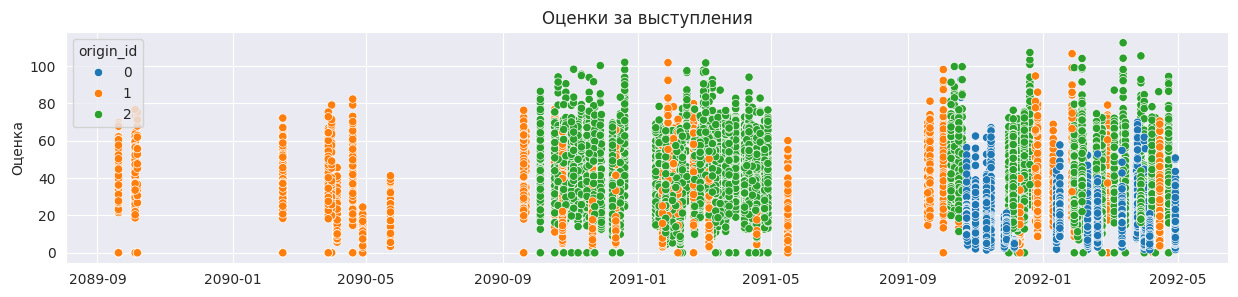

In [ ]:
# Create figure
plt.figure(figsize=(15, 3))
sns.scatterplot(x='date_start', y='elements_score', data=df, hue='origin_id')

plt.xlabel(None)
plt.ylabel('Оценка')
plt.title('Оценки за выступления')
plt.show()

Для предсказания выступлений спортсменов важно, чтобы они участвовали не в одном турнире, наиболее актуальны данные за последний сезон. Посмотрим, сколько спортсменов участвовали в скольких турнирах и когда.

In [ ]:
# create dataframe with skaters participation
units_presence = df.groupby('unit_id', as_index=False).agg({'date_start': 'min', 'date_end': 'max', 'tournament_id': 'nunique'})
units_presence['presence_days'] = (units_presence['date_end'] - units_presence['date_start']).dt.days
units_presence = units_presence.rename(columns={'date_start': 'first_date', 'date_end': 'last_date', 'tournament_id': 'tournaments_number' })
units_presence

,unit_id,first_date,last_date,tournaments_number,presence_days
0,1,2090-04-19,2092-04-26,15,738
1,3,2090-10-05,2092-04-26,12,569
2,4,2090-10-26,2091-12-17,6,417
3,5,2090-10-26,2092-04-16,6,538
4,6,2090-10-26,2092-04-26,12,548
...,...,...,...,...,...
3388,35003,2092-04-29,2092-05-03,1,4
3389,35004,2092-04-29,2092-05-03,1,4
3390,35005,2092-04-29,2092-05-03,1,4
3391,35006,2092-04-29,2092-05-03,1,4


In [ ]:
# Define the bins (days of participation)
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# count the number of skaters in each bin
pd.cut(units_presence['presence_days'], bins=bins).value_counts()

presence_days
(0, 100]       1550
(100, 200]      479
(400, 500]      317
(300, 400]      288
(500, 600]      257
(700, 800]      228
(600, 700]      133
(200, 300]       62
(900, 1000]      29
(800, 900]       21
Name: count, dtype: int64

In [ ]:
print('Количество турниров у спортсмена/количество спортсменов')
units_presence['tournaments_number'].value_counts()

Количество турниров у спортсмена/количество спортсменов


tournaments_number
1     1102
2      595
3      431
4      323
5      228
6      177
7      118
8       92
9       83
10      55
11      48
12      30
14      25
13      25
15      17
17      10
16       9
20       8
18       8
19       6
23       2
21       1
Name: count, dtype: int64

In [ ]:
print('Количество спортсменов, у которых 2 и > соревнований')
print((units_presence['tournaments_number']>1).sum())

Количество спортсменов, у которых 2 и > соревнований
2291


In [ ]:
# skaters with >1 tournaments during <40 days in the last presentes season
units_presence[(units_presence['tournaments_number']>1) & (units_presence['first_date']>'2091-08-30') & (units_presence['presence_days']<40)]

,unit_id,first_date,last_date,tournaments_number,presence_days
2081,2738,2092-03-29,2092-04-26,3,28
2082,2740,2092-03-29,2092-04-10,2,12
2086,2747,2092-03-15,2092-03-31,2,16
2092,2802,2092-02-19,2092-03-14,2,24
2093,2803,2092-03-12,2092-04-12,3,31
...,...,...,...,...,...
3297,34896,2092-04-06,2092-04-12,2,6
3321,34933,2092-04-06,2092-05-03,2,27
3324,34936,2092-04-06,2092-05-03,2,27
3328,34940,2092-04-06,2092-05-03,2,27


In [ ]:
df.query('unit_id==9686')

,total_score_id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str,errors,bonuses,color,school_id,date_start,date_end,origin_id,duration,season,tournament_order
4120,446213,9686,6150,26.23,23.51,50.18,26.67,0.0,3,6,short,q Пpыжoк пpизeмлён в чeтвepть x Haдбaвкa зa пpыжки вo втopoй пoлoвинe пpoгpaммы (10%),6,136.75,6,q,x,green,70,2092-02-06,2092-02-08,2,3,2091,39
4213,446236,9686,6150,44.61,42.94,86.57,44.63,-1.0,20,6,free,q Пpыжoк пpизeмлён в чeтвepть << Пoнижeнный пpыжoк x Haдбaвкa зa пpыжки вo втopoй пoлoвинe пpoгpaммы (10%) F Пaдeниe в элeмeнтe,6,136.75,6,"q,<<,F",x,green,70,2092-02-06,2092-02-08,2,3,2091,39
5538,447118,9686,6699,23.93,23.41,49.60,27.19,-1.0,17,12,short,x Haдбaвкa зa пpыжки вo втopoй пoлoвинe пpoгpaммы (10%),16,167.85,16,no,x,green,70,2092-02-23,2092-02-27,2,5,2091,45
5551,447110,9686,6699,19.90,0.00,47.16,24.08,-0.5,12,9,other,Cнижeния@@@Hapyшeниe вpeмeни:@@@-0.50@@@-0.50,16,167.85,16,no,no,green,70,2092-02-23,2092-02-27,2,5,2091,45
5565,447128,9686,6699,36.84,43.52,71.09,31.57,-4.0,14,25,free,q Пpыжoк пpизeмлён в чeтвepть << Пoнижeнный пpыжoк REP Пoвтopeниe пpыжкa нe в кacкaдe x Haдбaвкa зa пpыжки вo втopoй пoлoвинe пpoгpaммы (10%) F Пaдeниe в элeмeнтe,16,167.85,16,"q,<<,REP,F",x,green,70,2092-02-23,2092-02-27,2,5,2091,45
5650,447188,9686,6700,23.13,23.63,46.62,23.99,-1.0,24,17,short,<< Пoнижeнный пpыжoк x Haдбaвкa зa пpыжки вo втopoй пoлoвинe пpoгpaммы (10%) F Пaдeниe в элeмeнтe,12,146.19,12,"<<,F",x,green,70,2092-02-18,2092-02-23,2,6,2091,41
5663,447200,9686,6700,48.41,45.13,99.57,54.44,0.0,8,10,free,x Haдбaвкa зa пpыжки вo втopoй пoлoвинe пpoгpaммы (10%),12,146.19,12,no,x,green,70,2092-02-18,2092-02-23,2,6,2091,41


Около 1000 спортсменов участвовало всего в одном турнире, таких спортсменов можно оставить для рекомендаций на основе данных других спортсменов, но для прогноза надо хотя бы 2 турнира. Для 1500 спортсменов их "присутсвие" в данных представлено менее 100 днями, и лишь для 21го есть вероятно все три сезона. У некоторых спортсменов очень интенсивное участие в соревнованиях, например, за 40 дней они участвуют в трех турнирах. Это может сказаться на выполнении элементов как в лучшую, так и в худшую сторону.


#### Дней после предыдущего турнира
Рассчитаем для каждого спортсмена в последнем сезоне, сколько денй в среднем у него было между соревнованиями

In [ ]:
SEASON = 2091
# Sort data by unit and start_date
dur = (df
       .query('season == @SEASON')
       .groupby(['unit_id', 'tournament_id'], as_index=False)
       .agg({'date_start': 'min', 'date_end': 'max'})
       .sort_values(by=['unit_id', 'date_start']))

# Calculate the days between competitions
dur['prev_end'] = dur.groupby('unit_id')['date_end'].shift(1)
dur['days_after_prev'] = (dur['date_start'] - dur['prev_end']).dt.days
dur.loc[dur['days_after_prev']<0, 'days_after_prev'] = 0

# average number of days between tournaments for each skater
dur['avg_days_between'] = dur.groupby('unit_id')['days_after_prev'].transform('mean')

# Put 90 for the first tournament in season
dur['days_after_prev'] = dur['days_after_prev'].fillna(90)

dur.query('unit_id==78')

,unit_id,tournament_id,date_start,date_end,prev_end,days_after_prev,avg_days_between
105,78,6845,2091-10-25,2091-10-27,NaT,90.0,16.5556
106,78,6848,2091-11-11,2091-11-15,2091-10-27,15.0,16.5556
107,78,6849,2091-11-14,2091-11-17,2091-11-15,0.0,16.5556
101,78,4790,2091-12-05,2091-12-08,2091-11-17,18.0,16.5556
102,78,4992,2091-12-27,2091-12-28,2091-12-08,19.0,16.5556
103,78,5459,2092-01-10,2092-01-12,2091-12-28,13.0,16.5556
108,78,6860,2092-01-16,2092-01-20,2092-01-12,4.0,16.5556
104,78,6676,2092-02-28,2092-03-01,2092-01-20,39.0,16.5556
109,78,7106,2092-04-01,2092-04-05,2092-03-01,31.0,16.5556
110,78,7114,2092-04-15,2092-04-20,2092-04-05,10.0,16.5556


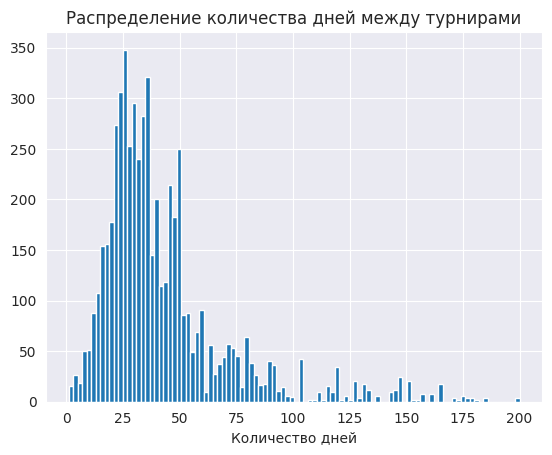

In [ ]:
dur['avg_days_between'].hist(bins=100)
plt.xlabel('Количество дней')
plt.title('Распределение количества дней между турнирами')
plt.show()

Видно, что есть спортсмены, у которых очень большые промежутки между соревнованиями, но как правило они составляют менее 50 дней.

#### Место, занятое после программы в предыдущем турнире

Рассчитаем для каждого спортсмена, какое место он занял после определенной программы в предыдущем турнире.



In [ ]:
# Sort values by skater and day of tournament start
df.sort_values(by=['unit_id', 'date_start'], inplace=True)

# Take previous place according segment
df['previous_place'] = df.groupby(['unit_id', 'segment_name'])['place'].shift(1)
df['previous_place'] = df['previous_place'].fillna(0).astype(int)
df[['unit_id', 'tournament_id',
    'date_start', 'segment_name',
    'place', 'previous_place']].head(10)

,unit_id,tournament_id,date_start,segment_name,place,previous_place
17856,1,84,2090-04-19,free,7,0
17858,1,84,2090-04-19,short,13,0
10357,1,3,2090-10-05,short,27,13
9020,1,1,2090-11-29,free,4,7
9028,1,1,2090-11-29,short,5,27
17854,1,21,2091-01-20,short,5,5
17868,1,21,2091-01-20,free,4,4
17874,1,33,2091-02-21,short,13,5
17885,1,33,2091-02-21,free,15,4
15280,1,43,2091-03-24,free,8,15


Тут стоит учесть, что есть соревноваия, где было больше одной короткой и произвольной программы, в них предыдущее место для повторной программы будет внутри соревнования, что не совсем корректно, надо брать из предыдущего, но на данном этапе оставим, как есть.

Создадим полный датасет для модели предсказания выполнения элементов.



### Датасет для построения модели

In [ ]:
df_model = (df_elements.drop(['fall_bonus', 'elements',
                             'note', 'note_list'], axis=1)
.merge(df, how='left'))

In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214554 entries, 0 to 214553
Data columns (total 45 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   total_score_id       214554 non-null  int64         
 1   title                214554 non-null  object        
 2   element_base_score   214554 non-null  float64       
 3   goe                  214554 non-null  float64       
 4   avg_score            214554 non-null  float64       
 5   element_type         214554 non-null  object        
 6   elements_order       214554 non-null  int64         
 7   +COMBO               214554 non-null  int64         
 8   q                    214554 non-null  int64         
 9   uur                  214554 non-null  int64         
 10  e                    214554 non-null  int64         
 11  ur                   214554 non-null  int64         
 12  ue                   214554 non-null  int64         
 13  V             

Удалим строки, где отсутсвует название программы, так как в них отсутсвуют и другие показатели.


In [ ]:
# Delete rows without segment name
df_model = df_model[df_model['segment_name'].notna()]

Создадим датафрейм для модели предсказания выступления спортсменов.
Из данных исключим все, что не можем знать заранее - обобщенные оценки, места, оценки за артистизм, дедукции, так как они ставятся за все выступления. id турнира заменим на порядковый номер для спортсмена в сезоне.

In [ ]:
df_model = df_model[['unit_id', 'color', 'school_id',
                     'tournament_id', 'tournament_order', 'origin_id',
                     'date_start', 'season', 'duration',
                     'segment_name', 'previous_place',
                     'element_type', 'elements_order', 'element', 'level',
                     'element_base_score', 'avg_score',
                     'V', 'q', 'ur', 'uur', 'ue', 'e',
                     'sum_errors', 'F','goe']]

Выделим факт, был ли исполнен прыжок в комбинации или отдельно в отдельную колонку.

In [ ]:
# create new column 'combination'
df_model['combination'] = np.where(df_model['element_type']=='combination', 1, 0)
df_model['element_type'] = np.where(df_model['element_type']=='combination', 'jump', df_model['element_type'])

Для каждого спортсмена для каждого выполняемого элемента найдем общую оценку и goe из предыдущих турниров. Однако, вероятно имеет смысл брать не только предпоследнее значение, но и усредненное или последние три.

In [ ]:
df_model = df_model.sort_values(by=['unit_id', 'date_start']).reset_index(drop=True)

# Dictionary to keep track of the last seen scores for each element for each skater
last_goe = {}
last_avg_score = {}
last_tournament = {}

# List to store the previous goe values
previous_goe = []
previous_avg_score = []

# Iterate through the DataFrame rows
for idx, row in df_model.iterrows():
    key = (row['unit_id'], row['combination'], row['element'], row['level'])

    # Check if the key exists in the dictionary
    if key in last_goe:
        # Check if the tournament is different
        if last_tournament[key] != row['tournament_order']:
            previous_goe_value = last_goe[key]
            previous_avg_score_value = last_avg_score[key]
        else:
            previous_goe_value = previous_goe[-1] if previous_goe else None
            previous_avg_score_value = previous_avg_score[-1] if previous_avg_score else None

    else:
        previous_goe_value = None
        previous_avg_score_value = None

    previous_goe.append(previous_goe_value)
    previous_avg_score.append(previous_avg_score_value)

    # Update the dictionary with the current GOE for the element
    last_goe[key] = row['goe']
    last_avg_score[key] = row['avg_score']

    last_tournament[key] = row['tournament_order']

# Add the previous_goe list as a new column in the DataFrame
df_model['prev_goe'] = previous_goe
df_model['prev_avg_score'] = previous_avg_score

#### Выбор сезона и количества турниров у спортсмена
Возьмем данные только за последний сезон 91/92, так как в нем представлены все три локации соревнований, к тому же при выборе данных только за один сезон мы уверены, что правила оценки выступления спортсменов одинаковые (рассчет гое, базовая стоимость элементов, правила, что считать за ошибки).

In [ ]:
df_model = df_model[df_model['season']==SEASON]
df_model.date_start.min()

Timestamp('2091-09-19 00:00:00')

Выберем только тех спортсменов, ку которых в этом сезоне больше 2 и больше турнира

In [ ]:
selected_unit_ids = list(df_model.groupby('unit_id').tournament_order.nunique()[df_model.groupby('unit_id').tournament_order.nunique()>1].index)
df_model = df_model[df_model['unit_id'].isin(selected_unit_ids)]

In [ ]:
print('Количество спортсменов для предсказания выступлений')
df_model.unit_id.nunique()

Количество спортсменов для предсказания выступлений


1583

Возьмем 10 произвольных спортсменов и посмотрим, как у них менялась оценка за определенный прыжок (возьмем прыжок с наибольшим количеством падений


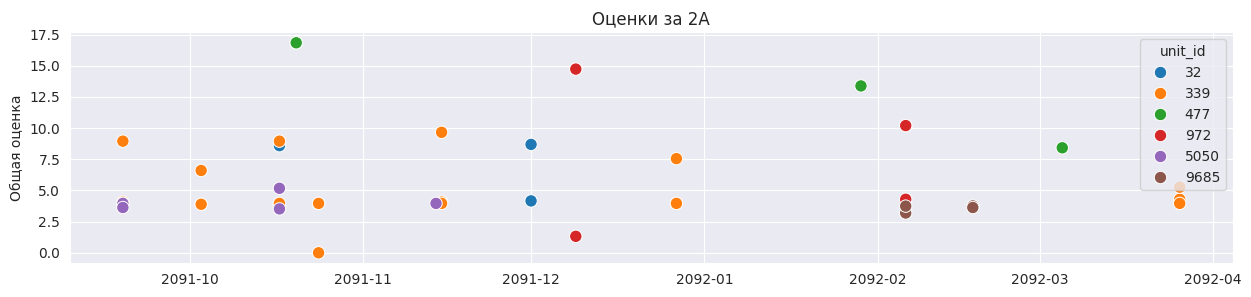

In [ ]:
# 10 random skaters
random_unit_id = np.random.choice(selected_unit_ids, size=10, replace=False)
# df for figure
ex = df_model[(df_model['unit_id'].isin(random_unit_id)) &
              (df_model['element']=="a") &
              (df_model['level']==2) &
              (df_model['element_type']=='jump')]

#ex = ex.groupby(['date_start', 'unit_id'], as_index=False).goe.median()

# Create figure
plt.figure(figsize=(15, 3))
sns.scatterplot(x='date_start', y='avg_score', data=ex,
                hue=ex['unit_id'].astype('category'), s=80, )

plt.xlabel(None)
plt.ylabel('Общая оценка')
plt.title('Оценки за 2А')
plt.show()

Добавим также признак - количество дней прошло после предыдущего турнира. Если соревнования очень интенсивные спортсмен может уставать и хуже выполнять программу. Для первого соревнования в сезоне укажем 90 - лето)



In [ ]:
# add average period between tournaments
df_model = df_model.merge(dur[['unit_id',	'tournament_id',
                               'days_after_prev']],
                          how='left', on = ['unit_id',	'tournament_id'])
df_model.query('unit_id==3')

,unit_id,color,school_id,tournament_id,tournament_order,origin_id,date_start,season,duration,segment_name,previous_place,element_type,elements_order,element,level,element_base_score,avg_score,V,q,ur,uur,ue,e,sum_errors,F,goe,combination,prev_goe,prev_avg_score,days_after_prev
167,3,green,75,7092,53,2,2092-03-29,2091,3,short,9,jump,1,f,3,10.2,10.94,0,0,0,0,0,0,0,0,0.74,1,NaN,NaN,90.0
168,3,green,75,7092,53,2,2092-03-29,2091,3,short,9,jump,1,lo,3,10.2,10.94,0,0,0,0,0,0,0,0,0.74,1,-0.59,9.13,90.0
169,3,green,75,7092,53,2,2092-03-29,2091,3,short,9,jump,2,a,2,3.3,4.03,0,0,0,0,0,0,0,0,0.73,0,0.66,3.96,90.0
170,3,green,75,7092,53,2,2092-03-29,2091,3,short,9,spin,3,fcsp,4,3.2,3.78,0,0,0,0,0,0,0,0,0.58,0,0.64,3.84,90.0
171,3,green,75,7092,53,2,2092-03-29,2091,3,short,9,jump,4,lz,3,5.9,7.67,0,0,0,0,0,0,0,0,1.77,0,-2.36,2.36,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,3,green,75,7115,63,2,2092-04-23,2091,4,free,1,jump,8,s,3,0.0,5.68,0,0,0,0,0,0,0,0,0.95,0,0.86,5.59,7.0
235,3,green,75,7115,63,2,2092-04-23,2091,4,free,1,jump,9,t,3,0.0,5.38,0,0,0,0,0,0,0,0,0.76,0,0.50,5.12,7.0
236,3,green,75,7115,63,2,2092-04-23,2091,4,free,1,spin,10,fccosp,4,3.5,4.27,0,0,0,0,0,0,0,0,0.77,0,0.70,4.20,7.0
237,3,green,75,7115,63,2,2092-04-23,2091,4,free,1,spin,11,lsp,4,2.7,3.29,0,0,0,0,0,0,0,0,0.59,0,0.70,4.20,7.0


In [ ]:
# check for duplicates
df_model.duplicated().sum()

533

In [ ]:
# Drop duplicates
df_model = df_model.drop_duplicates()
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88140 entries, 0 to 88672
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   unit_id             88140 non-null  int64         
 1   color               88140 non-null  category      
 2   school_id           88140 non-null  int64         
 3   tournament_id       88140 non-null  int64         
 4   tournament_order    88140 non-null  int64         
 5   origin_id           88140 non-null  category      
 6   date_start          88140 non-null  datetime64[ns]
 7   season              88140 non-null  int32         
 8   duration            88140 non-null  int64         
 9   segment_name        88140 non-null  object        
 10  previous_place      88140 non-null  int64         
 11  element_type        88140 non-null  object        
 12  elements_order      88140 non-null  int64         
 13  element             88140 non-null  object        


Посмотрим, сколько, например, недокрутов, для разных прыжков, исполненных отдельно.

In [ ]:
df_model.query('element_type=="jump"').groupby(['element', 'level'])['ur'].value_counts()

element  level  ur
a        1      0     5003
                1       52
         2      0     5630
                1      752
         3      0      601
                1       93
eu       1      0      981
f        1      0      403
                1        2
         2      0     4481
                1      969
         3      0     2758
                1      359
         4      0       19
                1        5
lo       1      0     1065
                1       22
         2      0     4431
                1     1136
         3      0     1914
                1      388
         4      0       28
                1        5
lz       1      0     1274
                1        3
         2      0     4715
                1      814
         3      0     3798
                1      418
         4      0       53
                1        8
s        1      0       56
         2      0     2714
                1      456
         3      0     2348
                1      605
         

In [ ]:
print("Количество разных фращений")
for lev in range(1, 5):
    print(f'Level {lev}')
    print(df_model.query('element_type=="spin" and level==@lev')['element'].value_counts())

Количество разных фращений
Level 1
element
chspl     1196
ccosp      749
cssp       363
fssp       360
lsp        183
ssp         84
ccsp        54
fcsp        41
csp         24
cosp        20
fcssp       15
fccosp       6
Name: count, dtype: int64
Level 2
element
ccosp     1015
fssp       912
lsp        397
cssp       250
fcsp       131
ssp        121
ccsp       118
fccosp      38
fcssp       33
csp         17
cosp         4
Name: count, dtype: int64
Level 3
element
ccosp     2843
fssp      1576
lsp        957
fcsp       268
cssp       251
ccsp       240
ssp        187
fccosp     177
fcssp       11
csp          4
Name: count, dtype: int64
Level 4
element
ccosp     3250
lsp       1731
fssp      1441
fccosp     617
fcsp       499
ccsp       427
cssp       323
ssp          8
flsp         7
csp          6
fcssp        4
Name: count, dtype: int64


In [ ]:
print("Количество разных сольных прыжков")
for lev in range(1, 5):
    print(f'Level {lev}')
    print(df_model.query('element_type=="jump" and level==@lev')['element'].value_counts())

Количество разных сольных прыжков
Level 1
element
a     5055
lz    1277
lo    1087
eu     981
f      405
t       74
s       56
Name: count, dtype: int64
Level 2
element
a     6382
lo    5567
lz    5529
f     5450
t     5117
s     3170
Name: count, dtype: int64
Level 3
element
lz    4216
f     3117
s     2953
t     2949
lo    2302
a      694
Name: count, dtype: int64
Level 4
element
t     287
s     169
lz     61
lo     33
f      24
Name: count, dtype: int64


#### Удаление ненужных и легких элементов

Удалим все строки с элементами-шагами.

In [ ]:
# drop rows with steps
print("Количество строк:", len(df_model))
df_model = df_model.loc[df_model['element_type']!='step']
print("Количество строк после удаления:", len(df_model))
(df_model['element_type']=='step').sum()

Количество строк: 88140
Количество строк после удаления: 80184


0

Удалим все строки с одинарными прыжками.

In [ ]:
# drop rows witр single jumps
df_model = df_model.loc[~((df_model['element_type']=='jump') & (df_model['level']==1))]
print("Количество строк после удаления:", len(df_model))
((df_model['element_type']=='jump') & (df_model['level']==1)).sum()

Количество строк после удаления: 71249


0

Еще раз посмотрим, в каких вращениях ошибались спортсмены, вероятно вращения, в которых ни у кого практически нет ошибок можно удалить (в идеале это следовало бы сделать после выделения тестовой выборки)





In [ ]:
# % clear spins
(df_model
 .query('sum_errors==0 and F==0 and element_type=="spin"')
 .groupby('element')['level']
 .value_counts()
 .div(df_model
      .query('element_type=="spin"')
      .groupby('element')['level']
      .value_counts())
 )

element  level
ccosp    4        0.9822
         3        0.9370
         2        0.7675
         1        0.7570
         0        0.7121
ccsp     4        1.0000
         3        1.0000
         2        0.9492
         1        0.9074
         0        0.8824
chspl    1        0.9833
         0        0.9545
cosp     0        0.4792
         1        0.6000
         2        0.2500
csp      0        0.9658
         1        1.0000
         2        1.0000
         4        1.0000
         3        1.0000
cssp     0        0.9282
         1        0.9532
         4        0.9969
         3        0.9721
         2        0.9480
fccosp   4        0.9822
         3        0.8588
         2        0.6579
         0        0.5000
         1        0.5000
fcsp     4        1.0000
         3        0.9963
         2        1.0000
         1        0.9512
         0        0.9286
fcssp    2        0.8182
         1        0.6667
         3        0.9091
         4        1.0000
         0

In [ ]:
# save element names and levels with clear performance < 80%
res = (df_model
       .query('sum_errors==0 and F==0 and element_type=="spin"')
       .groupby('element')['level']
       .value_counts()
       .div(df_model
            .query('element_type=="spin"')
            .groupby('element')['level']
            .value_counts()))

idxs = res[res < 0.8].index
idxs_list = list(idxs)

 # Create a  mask for rows to drop
mask = df_model.apply(lambda row: (row['element'], row['level']) in idxs_list, axis=1)

In [ ]:
df_model[~mask].query('element=="fccosp" and level==1')

,unit_id,color,school_id,tournament_id,tournament_order,origin_id,date_start,season,duration,segment_name,previous_place,element_type,elements_order,element,level,element_base_score,avg_score,V,q,ur,uur,ue,e,sum_errors,F,goe,combination,prev_goe,prev_avg_score,days_after_prev


In [ ]:
# drop rows with spins which have > 80% of clear performance
print("Количество строк:", len(df_model))
df_model = df_model[~mask]
print("Количество строк после удаления:", len(df_model))

Количество строк: 71249
Количество строк после удаления: 68785


In [ ]:
# % number of spins
(df_model
 .query('element_type=="spin"')
 .groupby('element')['level']
 .value_counts())

element  level
ccosp    4        3250
         3        2843
ccsp     4         427
         3         240
         2         118
         1          54
         0          34
chspl    1        1196
         0          66
csp      0         468
         1          24
         2          17
         4           6
         3           4
cssp     0         571
         1         363
         4         323
         3         251
         2         250
fccosp   4         617
         3         177
fcsp     4         499
         3         268
         2         131
         1          41
         0          14
fcssp    2          33
         3          11
         4           4
         0           2
flsp     4           7
fssp     3        1576
         4        1441
         2         912
         1         360
lsp      4        1731
         3         957
         2         397
         1         183
         0          18
ssp      0         481
         3         187
         2         

In [ ]:
# save element names and levels with clear performance < 80%
res = (df_model
       .query('element_type=="spin"')
       .groupby('element')['level']
       .value_counts())

idxs = res[res < 10].index
idxs_list = list(idxs)

 # Create a  mask for rows to drop
mask = df_model.apply(lambda row: (row['element'], row['level']) in idxs_list, axis=1)

In [ ]:
# drop rows with non-frequent spins
print("Количество строк:", len(df_model))
df_model = df_model[~mask]
print("Количество строк после удаления:", len(df_model))

Количество строк: 68785
Количество строк после удаления: 68754


In [ ]:
# fill Nan previous goe and average score with 0
df_model[['prev_avg_score', 'prev_goe']] = df_model[['prev_avg_score', 'prev_goe']] .fillna(0)
df_model.isna().sum()

unit_id               0
color                 0
school_id             0
tournament_id         0
tournament_order      0
origin_id             0
date_start            0
season                0
duration              0
segment_name          0
previous_place        0
element_type          0
elements_order        0
element               0
level                 0
element_base_score    0
avg_score             0
V                     0
q                     0
ur                    0
uur                   0
ue                    0
e                     0
sum_errors            0
F                     0
goe                   0
combination           0
prev_goe              0
prev_avg_score        0
days_after_prev       0
dtype: int64

In [ ]:
df_model = df_model[['unit_id', 'color', 'school_id',
                     'tournament_order', 'season', 'date_start',
                     'days_after_prev', 'origin_id',  'duration',
                     'segment_name', 'previous_place',
                     'element_type', 'combination', 'elements_order',
                     'element', 'level', 'prev_goe', 'prev_avg_score',
                     'V', 'q', 'ur', 'uur', 'ue', 'e', 'F', 'goe']]

Выделим категориальные переменные.

In [ ]:
# categorical features
df_model_cat = ['unit_id', 'color', 'school_id',
                'origin_id', 'segment_name',
                'element_type', 'combination', 'element']

In [ ]:
df_model[df_model_cat] = df_model[df_model_cat].astype('category')
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68754 entries, 0 to 88672
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unit_id           68754 non-null  category      
 1   color             68754 non-null  category      
 2   school_id         68754 non-null  category      
 3   tournament_order  68754 non-null  int64         
 4   season            68754 non-null  int32         
 5   date_start        68754 non-null  datetime64[ns]
 6   days_after_prev   68754 non-null  float64       
 7   origin_id         68754 non-null  category      
 8   duration          68754 non-null  int64         
 9   segment_name      68754 non-null  category      
 10  previous_place    68754 non-null  int64         
 11  element_type      68754 non-null  category      
 12  combination       68754 non-null  category      
 13  elements_order    68754 non-null  int64         
 14  element           68754 non

#### train/test split

Выделим в качетве тестовой выборки последнее соревнование у каждого спортсмена.

In [ ]:
# Ensure data is sorted by skater and tournament day
df_model.sort_values(by=['unit_id', 'date_start'], inplace=True)

# Find the maximum 'date_start' for each 'unit_id'
max_dates = df_model.groupby('unit_id')['date_start'].transform('max')

# Filter the DataFrame to keep only rows with the maximum 'date_start' for each 'unit_id'
test = df_model[df_model['date_start'] == max_dates]
print("Размер тестовой выборки")
print(len(test))

# Remove the latest rows from the original DataFrame
train = df_model[~df_model.isin(test)].dropna()
print("Размер обучющей выборки")
print(len(train))

Размер тестовой выборки
18682
Размер обучющей выборки
50072


In [ ]:
print("Количество спортсменов обучение:")
print(train.unit_id.nunique())

print("\nКоличество спортсменов тест:")
print(test.unit_id.nunique())

Количество спортсменов обучение:
1583

Количество спортсменов тест:
1583


In [ ]:
# Phik correlation coefficients matrix
phik_overview = train.drop(['season', 'date_start'],axis=1).phik_matrix()

interval columns not set, guessing: ['tournament_order', 'days_after_prev', 'duration', 'previous_place', 'elements_order', 'level', 'prev_goe', 'prev_avg_score', 'V', 'q', 'ur', 'uur', 'ue', 'e', 'F', 'goe']


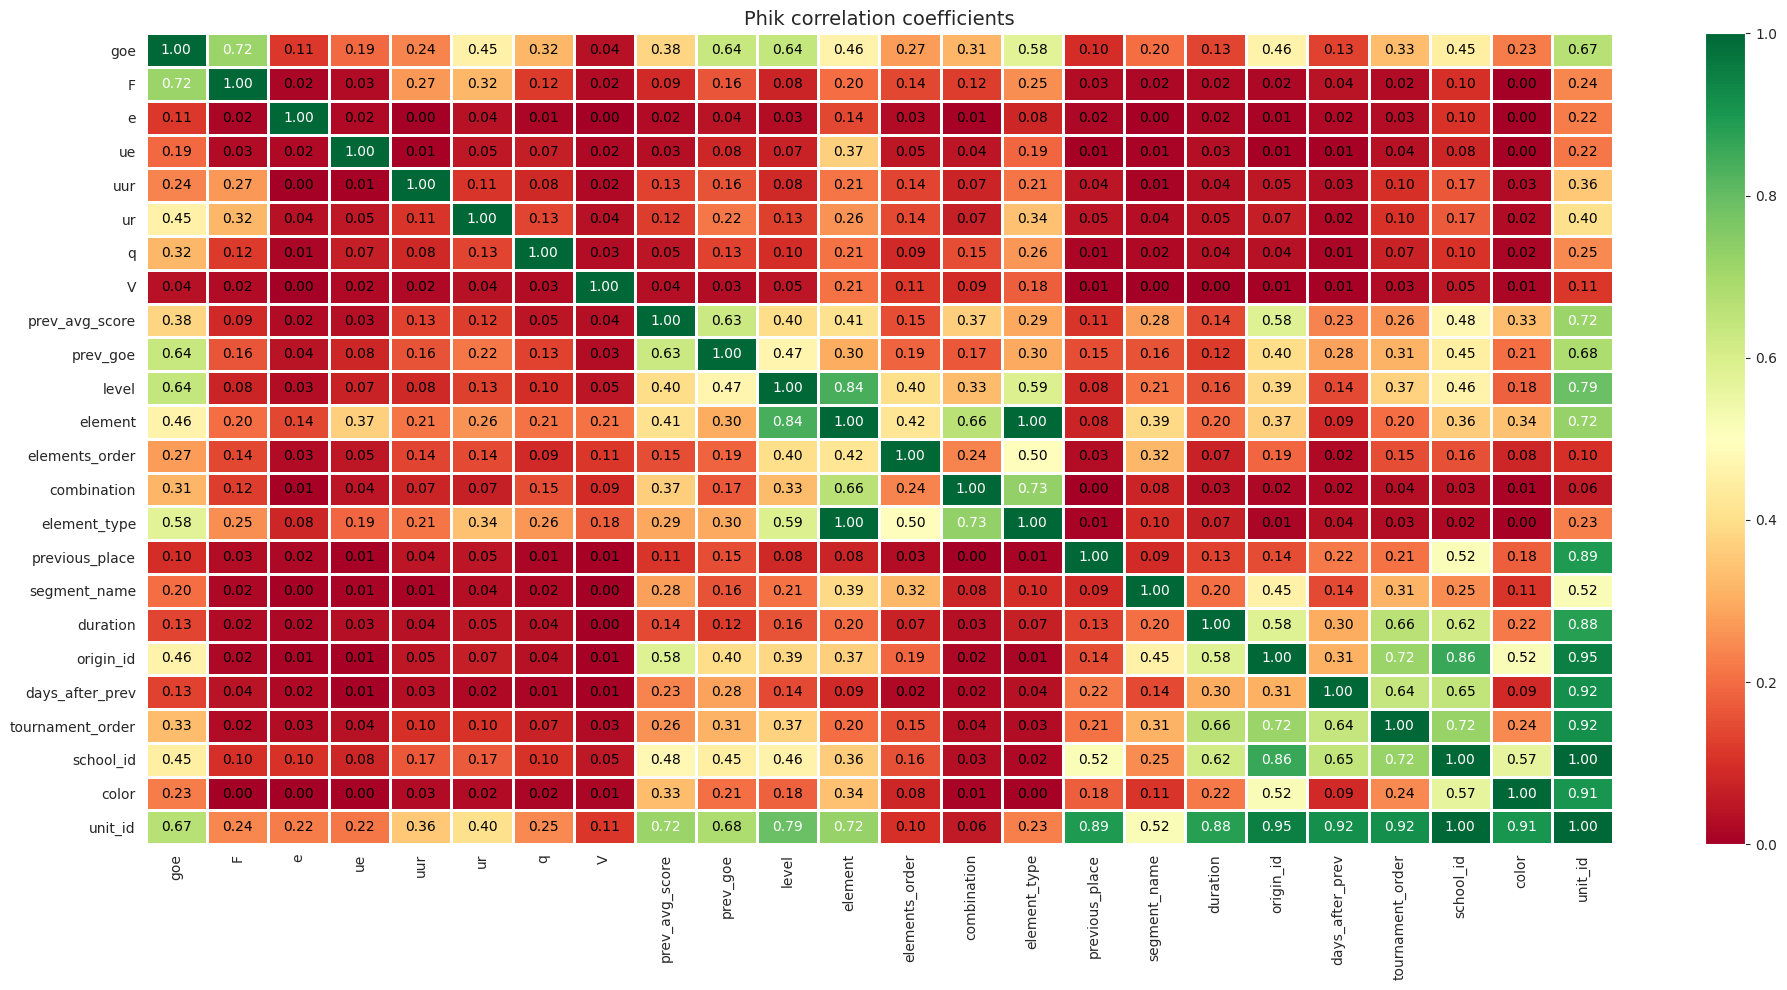

In [ ]:
# Plot Phik correlation coefficients matrix
plot_correlation_matrix(phik_overview.values,
                        x_labels=('unit_id', 'color', 'school_id', 'tournament_order',
                                  'days_after_prev', 'origin_id', 'duration',
                                  'segment_name', 'previous_place', 'element_type', 'combination',
                                  'elements_order', 'element', 'level', 'prev_goe',
                                  'prev_avg_score', 'V', 'q', 'ur', 'uur', 'ue',
                                  'e', 'F', 'goe'),
                        y_labels=('unit_id', 'color', 'school_id', 'tournament_order',
                                  'days_after_prev', 'origin_id', 'duration',
                                  'segment_name', 'previous_place', 'element_type', 'combination',
                                  'elements_order', 'element', 'level', 'prev_goe',
                                  'prev_avg_score', 'V', 'q', 'ur', 'uur', 'ue',
                                  'e', 'F', 'goe'),
                        title="Phik correlation coefficients",
                        figsize=(20, 10),
                        vmin=0, vmax=1)

Видно, что целевые признаки ошибок в выполнении элементов практически не коррелируют с другими признакам. Падение больше всего коррелирует с гое, что логично, слабо коррелирует с недокрутом в 90-180 оборота (<, ur), который в свою очередь слабо коррелирует со спортсменом и типом элемента; у ошибки нечеткого ребра (!, ue) слабая корреляция с элементом. GOE показывает более сильные корреляции- умеренная со спортсменом, уровнем элемента и предыдущим значением, более слабая с типом элемента.

#### Features/targets

In [ ]:
# target and features multi-label classification
X_train_clf = train.drop(train[['date_start', 'V', 'q', 'ur', 'uur', 'ue', 'e', 'F', 'goe']], axis=1)
Y_train_clf = train[['V', 'q', 'ur', 'uur', 'ue', 'e', 'F']]

X_test_clf = test.drop(train[['date_start', 'V', 'q', 'ur', 'uur', 'ue', 'e', 'F', 'goe']], axis=1)
Y_test_clf = test[['V', 'q', 'ur', 'uur', 'ue', 'e', 'F']]

# target and features regression
X_train_reg = train.drop(train[['date_start', 'goe']], axis=1)
y_train_reg = train[['goe']]

X_test_reg = X_test_clf
y_test_reg = test[['goe']]

## Базовые модели

В качестве целевых признаков мы решили выбрать ошибки в элементе  - задача multi-label классификации, и последующее предсказание goe - задача регрессии, в качестве базовой модели будем использовать градиентный бустинг CatBoost.

# Предсказание ошибок выполнения элементов

Тут стоит отметить, что данные сильно несбалансированы - отсутсвия ошибок намного больше. Для адекватного предсказания стоит провести и баллансировку. Оценивать модель стоит на кросс-валидации, что затруднено дисбаллансом и иерархичностью данных. На данном этаме это не было реализовано, как и балансировка классов.

In [ ]:
# create data pool for classification
train_pool_clf = Pool(X_train_clf, Y_train_clf, cat_features=df_model_cat)
test_pool_clf = Pool(X_test_clf, Y_test_clf, cat_features=df_model_cat)

In [ ]:
# Fit CatBoostClassifier object
clf = CatBoostClassifier(
    loss_function='MultiLogloss',
    iterations=500,
    class_names=['V', 'q', 'ur', 'uur', 'ue','e', 'F']
)
clf.fit(train_pool_clf, eval_set=test_pool_clf, metric_period=10, verbose=100)

Learning rate set to 0.112631
0:	learn: 0.5307673	test: 0.5290305	best: 0.5290305 (0)	total: 1.78s	remaining: 14m 50s
100:	learn: 0.1178551	test: 0.1220868	best: 0.1220868 (100)	total: 2m 19s	remaining: 9m 12s
200:	learn: 0.1117806	test: 0.1213711	best: 0.1213701 (180)	total: 4m 51s	remaining: 7m 14s
300:	learn: 0.1075833	test: 0.1214138	best: 0.1213693 (230)	total: 7m 16s	remaining: 4m 48s
400:	learn: 0.1037388	test: 0.1216443	best: 0.1213546 (310)	total: 9m 41s	remaining: 2m 23s
499:	learn: 0.0999185	test: 0.1221054	best: 0.1213546 (310)	total: 12m 5s	remaining: 0us

bestTest = 0.121354647
bestIteration = 310

Shrink model to first 311 iterations.


In [ ]:
# prediction on the train dataset
Y_pred_train = clf.predict(X_train_clf)

In [ ]:
# Evaluation on train
accuracy = accuracy_score(Y_train_clf, Y_pred_train)
f1 = f1_score(Y_train_clf, Y_pred_train, average='weighted')

print(f'Accuracy_train: {accuracy:.4f}')
print(f'F1 Score Train: {f1:.4f}')

Accuracy_train: 0.7845
F1 Score Train: 0.3039


In [ ]:
## prediction on the test data
Y_pred_clf = clf.predict(X_test_clf)

### Предсказание goe

Обучим модель на реальных данных с ошибками, а для тестовой выборки добавим предсказания ошибок предыдущей моделью.

In [ ]:
# Convert Y_pred_clf to DataFrame
Y_pred_df = pd.DataFrame(Y_pred_clf, columns=Y_test_clf.columns, index=X_test_reg.index)
Y_pred_df.sum()

V         0
q        10
ur     1063
uur     345
ue      190
e        14
F        84
dtype: int64

In [ ]:
Y_test_clf.sum()

V        87
q      1044
ur     1905
uur     868
ue      558
e       116
F      1327
dtype: int64

In [ ]:
# Merging X_test_clf with Y_pred_df
X_test_reg = pd.concat([X_test_reg, Y_pred_df], axis=1)
X_test_reg

,unit_id,color,school_id,tournament_order,season,days_after_prev,origin_id,duration,segment_name,previous_place,element_type,combination,elements_order,element,level,prev_goe,prev_avg_score,V,q,ur,uur,ue,e,F
143,1,green,198,63,2091,23.0,2,4,short,6,jump,0,1,a,2,0.86,4.16,0,0,0,0,0,0,0
144,1,green,198,63,2091,23.0,2,4,short,6,jump,1,2,lz,3,-0.47,11.15,0,0,0,0,0,0,0
145,1,green,198,63,2091,23.0,2,4,short,6,jump,1,2,t,2,1.18,8.38,0,0,0,0,0,0,0
146,1,green,198,63,2091,23.0,2,4,short,6,spin,0,3,lsp,4,0.59,3.29,0,0,0,0,0,0,0
147,1,green,198,63,2091,23.0,2,4,short,6,jump,0,4,f,3,1.06,6.89,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88656,34940,green,111,64,2091,21.0,0,5,free,43,spin,0,3,csp,0,0.00,0.00,0,0,0,0,0,0,0
88659,34940,green,111,64,2091,21.0,0,5,free,43,spin,0,6,ssp,0,0.00,0.00,0,0,0,0,0,0,0
88667,34957,green,0,64,2091,21.0,0,5,free,15,spin,0,2,ssp,0,0.00,0.00,0,0,0,0,0,0,0
88669,34957,green,0,64,2091,21.0,0,5,free,15,spin,0,4,chspl,1,-0.05,1.45,0,0,0,0,0,0,0


In [ ]:
# create pool of data for regression task
train_pool_reg = Pool(X_train_reg, y_train_reg, cat_features=df_model_cat)
test_pool_reg = Pool(X_test_reg, y_test_reg, cat_features=df_model_cat)

In [ ]:
# Fit CatBoostRegressor object
reg = CatBoostRegressor(random_state=RANDOM_STATE, iterations=500, loss_function='RMSE')
reg.fit(train_pool_reg, eval_set=test_pool_reg, verbose=False)

In [ ]:
# Make predictions on train data
y_pred_train = reg.predict(X_train_reg)

In [ ]:
# Make predictions on train data
y_pred_reg = reg.predict(X_test_reg)

In [ ]:
# Calculate RMSE
rmse = mean_squared_error(y_train_reg, y_pred_train, squared=False)
print(f'RMSE train: {rmse:.4f}')

RMSE train: 0.4681


### Тестирование моделей

Для проверки адекватности моделей сравним их с константной -  для классификации взьмем значения ошибок для каждого элемента из предпоследнего (или еще более раннего, если не найдется)  турнира, для задачи регрессии - возьмем медианное значение goe

In [ ]:
# Create the dummy model for multi-label Classification task
train_data = X_train_clf.copy()
train_data[Y_train_clf.columns] = Y_train_clf

# Initialize dummy predictions dataframe
dummy_predictions = pd.DataFrame(index=X_test_clf.index, columns=Y_test_clf.columns)

# Function to find the latest matching record
def find_latest_match(row, train_data):
    matches = train_data[
        (train_data['unit_id'] == row['unit_id']) &
        (train_data['element_type'] == row['element_type']) &
        (train_data['combination'] == row['combination']) &
        (train_data['element'] == row['element']) &
        (train_data['level'] == row['level'])
    ]
    if not matches.empty:
        latest_match = matches.iloc[-1]  # Assuming the last row is the latest
        return latest_match[Y_train_clf.columns]
    else:
        return pd.Series([0] * (len(Y_train_clf.columns)-1) + [1], index=Y_train_clf.columns)  # Default to no error and fall

# Generate dummy predictions
for idx, row in X_test_clf.iterrows():
    dummy_predictions.loc[idx] = find_latest_match(row, train_data)

# Ensure predictions are the correct dtype
dummy_predictions_clf = dummy_predictions.astype(int)

In [ ]:
# Create the dummy model for Regression task

train_data = X_train_reg.copy()
train_data['goe'] = y_train_reg

# Initialize dummy predictions dataframe
dummy_predictions_reg = pd.DataFrame(index=X_test_reg.index, columns=y_test_reg.columns)

# Function to find the latest matching record
def find_match_median(row, train_data):
    matches = train_data[
        (train_data['unit_id'] == row['unit_id']) &
        (train_data['element_type'] == row['element_type']) &
        (train_data['combination'] == row['combination']) &
        (train_data['element'] == row['element']) &
        (train_data['level'] == row['level'])
    ]
    if not matches.empty:
        return matches['goe'].median()
    else:
        return 0  # Default to no error

# Generate dummy predictions
for idx, row in X_test_reg.iterrows():
    dummy_predictions_reg.loc[idx] = find_match_median(row, train_data)

# Ensure predictions are the correct dtype
dummy_predictions_reg = dummy_predictions_reg.astype(int)

In [ ]:
# Evaluate classification
accuracy = accuracy_score(Y_test_clf, Y_pred_clf)
f1 = f1_score(Y_test_clf, Y_pred_clf, average='weighted')

accuracy_dummy = accuracy_score(Y_test_clf, dummy_predictions_clf)
f1_dummy = f1_score(Y_test_clf, dummy_predictions_clf, average='weighted')

print('\033[1mКачество классификации\033[0m')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

print(f'dummy_accuracy: {accuracy_dummy:.4f}')
print(f'dummy_F1 Score: {f1_dummy:.4f}')

Качество классификации
Accuracy: 0.7605
F1 Score: 0.2043
dummy_accuracy: 0.6185
dummy_F1 Score: 0.2939


In [ ]:
# Evaluate regression
rmse = mean_squared_error(y_test_reg, y_pred_reg, squared=False)
rmse_dummy = mean_squared_error(y_test_reg, dummy_predictions_reg, squared=False)

print('\033[1mКачество регрессии\033[0m')
print(f'RMSE: {rmse:.4f}')
print(f'RMSE_dummy: {rmse_dummy:.4f}')

Качество регрессии
RMSE: 0.7698
RMSE_dummy: 0.7922


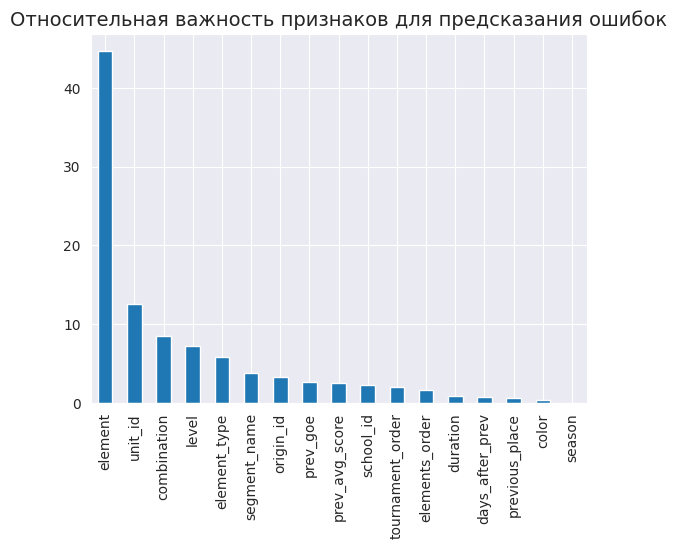

In [ ]:
# Importance of the features
feature_importances = pd.DataFrame(
    {'features': list(X_train_clf),
     'feature_importance': clf.feature_importances_})

# plot feature importances
feature_importances.sort_values(by='feature_importance', ascending=False).plot(kind='bar', x='features', legend=None)
plt.title('Относительная важность признаков для предсказания ошибок', fontsize=14)
plt.xlabel('')
plt.show()

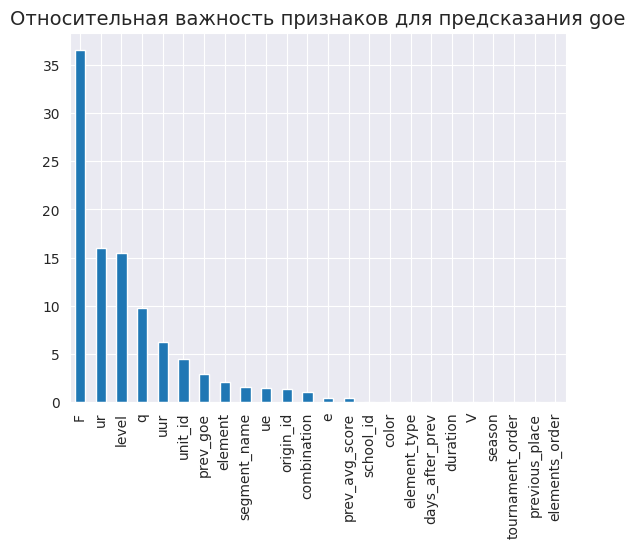

In [ ]:
# Importance of the features
feature_importances = pd.DataFrame(
    {'features': list(X_train_reg),
     'feature_importance': reg.feature_importances_})

# plot feature importances
feature_importances.sort_values(by='feature_importance', ascending=False).plot(kind='bar', x='features', legend=None)
plt.title('Относительная важность признаков для предсказания goe', fontsize=14)
plt.xlabel('')
plt.show()

# Применение модели

На данном этапе отсутсвует, так как модели не прошли проверку на адекватность и их следует дорабатывать.

# ОТЧЕТ
В настоящем проекте решалась исследовательская задача возможного предсказания выполнения одиночными фигуристами различных элементов на основании их предыдущей истории выступлений. Предсказание выполнения элементов может помочь тренерам принимать решение о составлении программы и добиться лучших результатов для спортсменов.

Для решения этой задачи было необходимо разработать модель машинного обучения, используя исторические данные о выступлениях фигуристов за определенный период. В качестве данных было предоставлено:
- Принадлежность спортсмена к школе и “категории”
-  Даты и места проведения турниров
- Данные о результатах выполнения в рамках разных программ турнира, включающие как общие данные, так и детализацию по элементам и ошибкам в них, а также оценку за выполнене, включающую базовую стоимость элемента с учетом ошибки при ее наличиии и субъективную судейскую оценку

Данные были предоставлены за 3 сезона, для 4596 спортсменов из 239 спортивных школ. Всего имеется информация для 142 соревнований в 3х локациях.<br>
Предварительный анализ данных выявил некоторые особенности и проблемы:
- Небольшое количество данных, не включающих признаки, которые могли бы более явно коррелировать с успешностью выполнения элементов.
- Не у всех спортсменов указаны их школы, соотношение “категорий” у спортсенаов неодинаковое -'lime', в 4 раза меньше, количество спортсменов, представляющих школы разное – от 1 до более 300.
- Не все три сезона представлены одинаковым количеством соревнований в одинаковых локациях – только у последнего сезона имеются все три локации турниров (а локация турнира также может говорить об уровне спортсменов, участвующих в нем). Турниры разные по сложности, количеству участников, продолжительности. Тут возникает вопрос, стоит ли смешивать спортсменов сильно разного уровня – одни будут ошибаться и в более простых элементах, другие – нет.
- В данных, где есть строки на кириллице – она смешана с латинскими схожими символами.
- В данных о выступлениях спортсменов есть пропуски по некоторым показателям - тип программы, общая оценка, информация о выступлении, в данных о выполненных в рамках выступления элементах - только для четверти случаев указана информация о снижении оценки/присвоении бонуса (возможно снижений и бонусов не было). Часто отсутсвующие значения (например, базовая стоимость элементов) указаны как нули, что вводит в заблуждение, тк это могут быть и истинные значения. Количество надбавок за выполнение элемента во второй части программы зачастую не указано для конкретных элементов – а в большинстве общих данных о выступлении есть.
- В некоторых случаях есть неуверенность, что считать ошибкой элемента (иногда *, иногда специальные пометки), что требует уточнений от специалистов/заказчика для предотвращения произвольного толкования.
- Есть разные сезоны соревнований, но мы не знаем, какие – а правила соревнований и оценок спортсменов могут меняться от сезона к сезону.
- Данные неполные – для многих случаев у спортсмена есть только произвольная программа, а такого не может быть, короткая программа идет первойю. В одном соревновании мб по 2 коротких и произвольных программы. Также есть программы, не характерные для взрослых спортсменов – “Прыжки”, “Элементы”, “Интерпретации”, что опять же говорит о том, что имеются очень разные уровни спортсменов.
- У всех спортсменов разная история выступлений – у кого-то насыщенная по три турнира в месяц, у кого-то по 1 в год. У многих спортсменов есть информация только об одном турнире.

Ключевыми шагами при выполнении проекта стали:
1.	Предобработка и анализ данных
2.	Генерация признаков
3.	Объединение данных в один датасет
4.	Анализ взаимодействия признаков и их влияния на целевой признак
5.	Отбор признаков
6.	Разработка базовой модели
7.	Тестирование базовой модели

В настоящем проекте **наибольшую трудность** представил "дизайн" необходимых признаков и целевых переменных, связанный с предобработкой данных. Не очень очевидно, как имеющиееся данные могли быть связаны с успешностью выполнения элемента. Данные иерархичны – у каждого спортсмена есть несколько турниров, в каждом турнире не одна программа, в каждой программе спортсмен выполняет разные элементы. Другой сложностью стало отсутвие знаний по предметной области проекта, отчасти она была решена общением с фигуристкой, приглашенной на вебинар, отчасти благодаря изучению информации в интернете. Более эффективно решить эту сложность можно было бы при общении со специалистом в предметной области.

Было решено взять данные только за **последний сезон** и только для спортсменов, у которых есть **более 1 турнира**. Итоговый датасет включил данные для около 1500 спортсменов. Комбинации элементов были разделены на отдельные составляющие, выделены ошибки и падения при их исполнении.<br>
В качестве признаков были выбраны:  
1.	id спортсмена, так как в будущем мы хотим предсказывать выполнение элементов конкретным спортсменом
2.	Категория соревнований – если это одиночное катание, то это мб одиночное мужсие/женские выступления, а значит выполнение элементов может существенно различаться
3.	Школа спортсмена – от уровня школы зачастую зависит уровень спортсмена. Отсутвующие значения были заполнены 0.
4.	Номер турнира в сезоне – интенсивность выступлений может говорить об уровне спортсмена/сказываться на его выступлениях.
5.	Количество дней после последнего турнира и длительность турнира – также могут сказываться на выступлении спортсмена. Для первого выступления в сезоне указывалось 90.
6.	Локация соревнования, мб в областном центре или области – уровень соревнований будет разный
7.	Тип программы и место, которое занял спортмен с такой программой в предыдущем соревновании, если ранее не было такой программы указывался 0.
8.	Тип элемента – прыжки, вращения, шаги.
9.	Был ли выполнен прыжок в комбинаци или нет – влияет и на вид и на выполнение прыжка.
10.	Порядковый номер элемента в программе – ближе к концу спортсмен устает и может хуже выполнять элементы, однако за них начисляется надбавка в 10%, успешность выполнения элемента в конце программы может говорить об уровне спортсмена (тут стоит отметить, что когда количество одинаковых программ больше одной – это было место в рамках одного турнира, что не совсем корректно).
11.	Название элемента – буквенный код, элементы очень разные по сложности.
12.	Уровень элемента – для прыжков – количество вращений, для вращений – уровень. Если уровень не был указан – для прыжков указывалось 1, для вращений 0 (В – обозначался как 0).
13.	Предыдущее goe и средняя оценка – значения для конкретного элемента, исполненного в предыдущих турнирах. Если не было найдено – указывалось 0.

В качестве целевых переменных были выбраны:
1.	Для multi-label классификации – типы ошибок в выполнении элемента.
- V – ошибка во вращении
- 'q' – недокрут в ¼
- 'ur' - <, недокрут 90-180
- 'uur' - <<, недокрут >180
- 'ue' – нечеткое ребро (для F/Lz)
- 'e' – неправильное ребро
 - 'F' – падение, включает ошибку в выполенении комбинации/ последовательности, когда было падение, касание/перенос веса на другую ногу между прыжками (+COMBO, +SEQ между прыжками)
2.	goe – судейская оценка. Тут важно отметить, что для прыжков, выполненных в комбинации было указано одинаковое значение для всех прыжков, что не корректно – слодовало указать значение для старшего прыжка, а для ддругих указать 0 (это относится и к предыдущим значениям goe и общей оценки, которую стоило взять из таблиц с учетом ошибок)

Было решено не считать ‘*’ в качестве ошибки, что не всегда может быть корректно, тут следует проконсультироваться со специалистами.

**Подготовка данных для модели**:<br>
Помимо выбора последнего сезона и количества турниров было решено исключить шаги, все одинарные прыжки, так как спортсмены в них практически не ошибаются, и некоторые виды вращений – редкие (встречались меньше 10) и которые в большинстве случаев спортсмены выполняли чисто (были взяты только те, где исполнение без ошибок и падений было в менее 80%). Здесь стоило удалять рассчитывать такие вращения ТОЛЬКО на обучающей выборке.

**Особенности данных.**<br>
Данные иерархичные и сильно несбалансированы, количества ошибок очень мало в сравнении с правильным выполнением. Для адекватных предсказаний следует произвести баллансировку данных или удалять те, элементы, в которых спортсмены не ошибаются, но тут следует помнить, что у нас очень разный уровень спортсменов.<br>
При анализе связей между признаками не видно, что ошибки выполнения элементов значительно коррелируют с имеющимися признаками, для goe – ситуация лучше -  он показывает более сильные корреляци: сильную с наличием падения, умеренную со спортсменом, уровнем элемента и предыдущим
значением, более слабую с типом элемента.

**Разработка и тестирование моделей**<br>
Для задачи данного проекта в качестве базовой модели был выбран градиентный бустинг CatBOOST. Предсказание проводилось в 2 этапа:
1.	Предсказание ошибок с помощью multi-label классификации (CatBoostClassifier)
2.	При использовании предсказанных ошибок – предсказание goe (CatBoostRegressor)

Модель предсказания ошибок не прошла проверку на адекватность – константная модель, предсказывающая была ли ошибка в элементе в предыдущем турнире имеет более высокую точность.<br>
*Качество классификации*<br>
Accuracy: 0.7605<br>
F1 Score: 0.2043<br>
dummy_accuracy: 0.6185<br>
dummy_F1 Score: 0.2939<br>
Для модели самым важным было название элемента.<br>

Качество предсказания goe лишь немногим лучше константной модели, предсказывающей медианные значения из предыдущих соревнований.<br>
*Качество регрессии*<br>
RMSE: 0.7698<br>
RMSE_dummy: 0.7922<br>
Для модели самым важным была информация о падении, уровне элемента и наличии недокрута.<br>
Данные о важности признаков согласуются с тем, что было видно во взаимосвязи признаков.

**Рекомендации по улучшению модели**<br>
Необходимо провести баллансировку классов. Вероятно стоит объединить все ошибки.  
Для улучшения качества модели можно попробовать различные алгоритмы отбора признаков и подбор гиперпараметров модели. Вероятно стоит добавить как признаки еще предыдущие значения. 
Стоит провести анализ ошибок моделей. Провести корректировку недочетов, указанных в признаках. 
Предсказывать только те элементы, у которых высокий процент ошибок.  
Использовать нейронные сети, способные к обучению долговременным зависимостям (LSTM).

**Рекомендации заказчику**<br>
•	По возможности добавить и другие данные о спортсменах
•	Добавить больше спортсменов/ турниров / программ